<a href="https://colab.research.google.com/github/antonellagambarte/CEIA-MLOps1-TP/blob/main/entrega%20final/modelos_con_feature_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline Optimizado para Clasificación de Enfermedades en Plantas

Este notebook mejora el pipeline anterior con las siguientes optimizaciones:

1. **Eliminación de imágenes duplicadas**: Detectamos y removemos imágenes duplicadas usando hashing perceptual para evitar sesgos en el entrenamiento
2. **Data Augmentation en clases subrepresentadas**: Aplicamos aumento de datos específicamente en las clases con menor representación para balancear el dataset
3. **Búsqueda de hiperparámetros con Optuna**: Optimizamos automáticamente learning rate, batch size, y arquitectura del clasificador.
4. Se agrega las distribuciones de color como feature.

**Modelos a comparar:**
- MobileNetV2
- MobileNetV3

**Objetivo**: Maximizar recall y accuracy mientras mantenemos el modelo lo suficientemente ligero para deployment móvil.


In [ ]:
test_execution = False


## Imports y Configuración Inicial


In [ ]:
!pip install optuna

In [ ]:
import gdown
import zipfile
import os
import time
import copy
import hashlib
from pathlib import Path
from collections import Counter, defaultdict
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score,
                            f1_score, roc_curve, auc, precision_recall_curve,
                            average_precision_score)
from sklearn.preprocessing import LabelBinarizer

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torch.ao.quantization import get_default_qconfig_mapping, get_default_qat_qconfig_mapping
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, prepare_qat_fx

import optuna
from optuna.trial import TrialState
import warnings

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Para asegurar reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Silenciar warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


Usando dispositivo: cuda


## Carga del Dataset


In [ ]:
url = "https://drive.google.com/uc?id=1EAe3-k6Mj6UBd3uEA3gtotnSxtIIEkri"
output = "archivo.zip"
destino = "datos_zip"

def zip_is_valid(path):
    if not os.path.isfile(path) or os.path.getsize(path) == 0:
        return False
    try:
        with zipfile.ZipFile(path, 'r') as z:
            return z.testzip() is None
    except Exception as e:
        print("Error:", e)
        return False

# Descargar solo si no existe o si el zip es inválido
if not zip_is_valid(output):
    print("Descargando dataset...")
    gdown.download(url, output, quiet=False, fuzzy=True)
else:
    print(f"'{output}' ya existe.")

os.makedirs(destino, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

print("Archivo extraído correctamente en:", destino)


'archivo.zip' ya existe.
Archivo extraído correctamente en: datos_zip


## 1. Detección y Eliminación de Duplicados

Utilizamos hashing  para detectar imágenes duplicadas.
Esto previene que el modelo memorice la misma imagen y mejora la generalización.


In [ ]:
def compute_file_hash(image_path, algo="md5", chunk_size=8192):
    """
    Calcula un hash exacto del archivo de imagen.
    Esto detecta imágenes idénticas (bit a bit).
    """
    hash_func = hashlib.md5() if algo == "md5" else hashlib.sha256()

    try:
        with open(image_path, "rb") as f:
            while chunk := f.read(chunk_size):
                hash_func.update(chunk)
        return hash_func.hexdigest()
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

def find_duplicate_images(data_dir, algo="md5"):
    """
    Encuentra imágenes duplicadas exactas (mismo contenido).
    Retorna dict {hash: [paths]} donde paths > 1 son duplicados.
    """
    hash_dict = defaultdict(list)

    print("Calculando hashes exactos...")
    for root, dirs, files in os.walk(data_dir):
        for file in tqdm(files, desc=f"Procesando {os.path.basename(root)}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img_hash = compute_file_hash(file_path, algo)

                if img_hash:
                    hash_dict[img_hash].append(file_path)

    # Filtrar solo duplicados
    duplicates = {h: paths for h, paths in hash_dict.items() if len(paths) > 1}
    return duplicates


def remove_duplicates(data_dir, duplicates_dict):
    """
    Elimina imágenes duplicadas, manteniendo solo una copia de cada grupo.
    """
    removed_count = 0

    for img_hash, paths in duplicates_dict.items():
        # Mantener la primera imagen, eliminar el resto
        for path_to_remove in paths[1:]:
            try:
                os.remove(path_to_remove)
                removed_count += 1
            except Exception as e:
                print(f"Error eliminando {path_to_remove}: {e}")

    return removed_count


In [ ]:
# Ejecutar detección y eliminación de duplicados
data_dir = "datos_zip/plantvillage dataset/color"

print("="*70)
print("PASO 1: DETECCIÓN Y ELIMINACIÓN DE DUPLICADOS")
print("="*70)

duplicates = find_duplicate_images(data_dir)

if duplicates:
    print(f"\n📊 Se encontraron {len(duplicates)} grupos de imágenes duplicadas")
    print(f"   Total de imágenes duplicadas: {sum(len(paths)-1 for paths in duplicates.values())}")

    # Mostrar algunos ejemplos
    print("\n📋 Primeros 5 grupos de duplicados:")
    for i, (img_hash, paths) in enumerate(list(duplicates.items())[:5]):
        print(f"  Grupo {i+1}: {len(paths)} copias")
        for path in paths[:3]:  # Mostrar max 3 paths
            print(f"    - {path}")

    # Eliminar duplicados
    print("\n🗑️ Eliminando duplicados...")
    removed = remove_duplicates(data_dir, duplicates)
    print(f"✅ Se eliminaron {removed} imágenes duplicadas")
else:
    print("✅ No se encontraron duplicados en el dataset")


PASO 1: DETECCIÓN Y ELIMINACIÓN DE DUPLICADOS
Calculando hashes exactos...


Procesando color: 0it [00:00, ?it/s]
Procesando Soybean___healthy: 100%|██████████| 5090/5090 [00:00<00:00, 17501.04it/s]
Procesando Cherry_(including_sour)___Powdery_mildew: 100%|██████████| 1409/1409 [00:00<00:00, 12293.56it/s]
Procesando Grape___Esca_(Black_Measles): 100%|██████████| 1410/1410 [00:00<00:00, 17017.00it/s]
Procesando Orange___Haunglongbing_(Citrus_greening): 100%|██████████| 5507/5507 [00:00<00:00, 18850.46it/s]
Procesando Corn_(maize)___Common_rust_: 100%|██████████| 1410/1410 [00:00<00:00, 12782.32it/s]
Procesando Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████| 5357/5357 [00:00<00:00, 17083.70it/s]
Procesando Strawberry___Leaf_scorch: 100%|██████████| 1410/1410 [00:00<00:00, 10733.82it/s]
Procesando Tomato___Spider_mites Two-spotted_spider_mite: 100%|██████████| 1676/1676 [00:00<00:00, 13705.27it/s]
Procesando Potato___Early_blight: 100%|██████████| 1410/1410 [00:00<00:00, 10426.88it/s]
Procesando Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 100%|██████████|


📊 Se encontraron 21 grupos de imágenes duplicadas
   Total de imágenes duplicadas: 21

📋 Primeros 5 grupos de duplicados:
  Grupo 1: 2 copias
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/5688ea99-c949-41d0-bbab-9cbf0ffb8bcd___GHLB2 Leaf 8677.JPG
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/e20107e7-137f-400e-817f-5dc4c58e5d70___GHLB2 Leaf 8677.JPG
  Grupo 2: 2 copias
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/2c47b891-3c97-48f1-a2cc-5aa53d3a1148___GHLB2 Leaf 9011.JPG
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/1a69b38b-c4eb-42c4-9584-bcb14fb8db0c___GHLB2 Leaf 9011.JPG
  Grupo 3: 2 copias
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/861d8b00-57a4-46b0-b51a-09d102dbe119___GHLB_PS Leaf 24 Day 13.jpg
    - datos_zip/plantvillage dataset/color/Tomato___Late_blight/d82b634e-9a19-497b-b698-aaf100d622a1___GHLB_PS Leaf 24 Day 13.jpg
  Grupo 4: 2 copias
    - datos_zip/plantvillage dataset/color/To

## 2. Análisis de Distribución de Clases

Analizamos cuántas imágenes tiene cada clase para identificar desbalance.


PASO 2: ANÁLISIS DE DISTRIBUCIÓN DE CLASES

📊 Dataset Statistics:
   Total de clases: 38
   Total de imágenes: 69010
   Promedio por clase: 1816.1

📉 Top 10 clases con MENOS imágenes:
   Cherry_(including_sour)___Powdery_mildew          :  1409 imágenes (2.04%)
   Potato___healthy                                  :  1409 imágenes (2.04%)
   Strawberry___healthy                              :  1409 imágenes (2.04%)
   Pepper,_bell___Bacterial_spot                     :  1409 imágenes (2.04%)
   Apple___Cedar_apple_rust                          :  1410 imágenes (2.04%)
   Potato___Late_blight                              :  1410 imágenes (2.04%)
   Tomato___Target_Spot                              :  1410 imágenes (2.04%)
   Apple___Black_rot                                 :  1410 imágenes (2.04%)
   Peach___healthy                                   :  1410 imágenes (2.04%)
   Raspberry___healthy                               :  1410 imágenes (2.04%)

📈 Top 10 clases con MÁS imágenes:
 

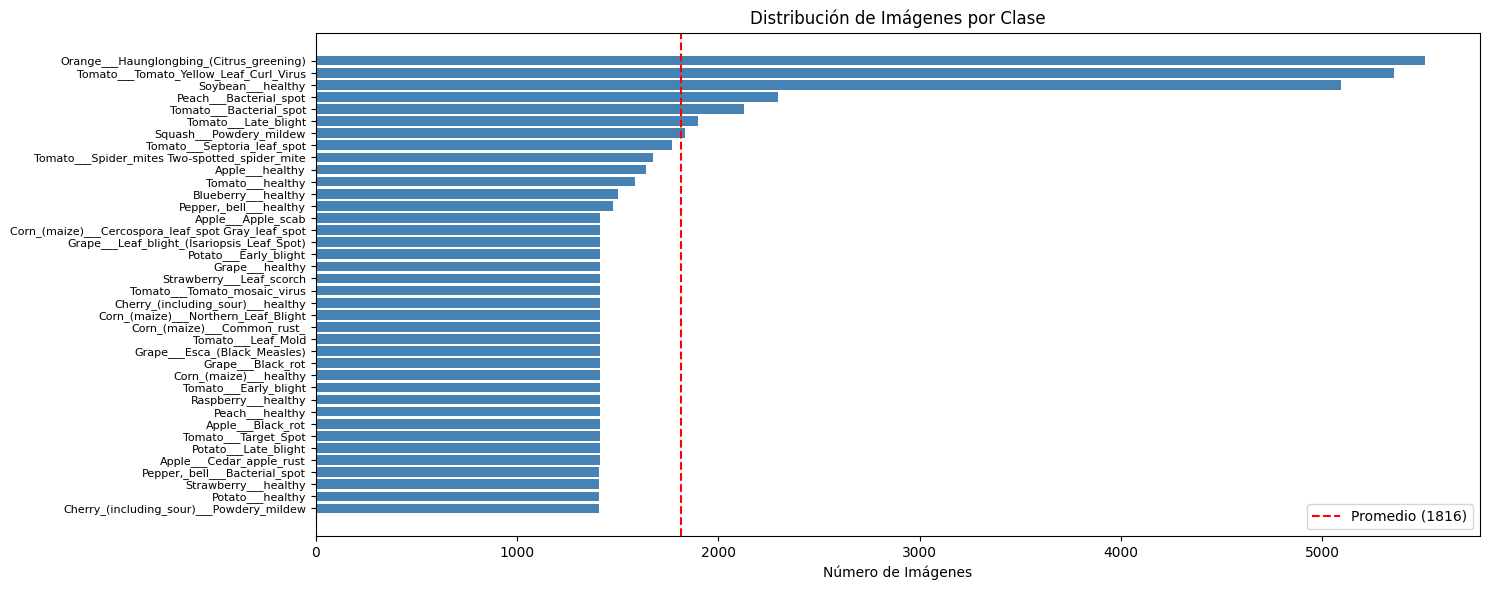


⚠️ Clases con representación baja (< 80% del promedio):
   25 clases requieren augmentation
   Cherry_(including_sour)___Powdery_mildew          :  1409 → necesita ~  43 imágenes más
   Potato___healthy                                  :  1409 → necesita ~  43 imágenes más
   Strawberry___healthy                              :  1409 → necesita ~  43 imágenes más
   Pepper,_bell___Bacterial_spot                     :  1409 → necesita ~  43 imágenes más
   Apple___Cedar_apple_rust                          :  1410 → necesita ~  42 imágenes más
   Potato___Late_blight                              :  1410 → necesita ~  42 imágenes más
   Tomato___Target_Spot                              :  1410 → necesita ~  42 imágenes más
   Apple___Black_rot                                 :  1410 → necesita ~  42 imágenes más
   Peach___healthy                                   :  1410 → necesita ~  42 imágenes más
   Raspberry___healthy                               :  1410 → necesita ~  42 imágenes m

In [ ]:
def analyze_class_distribution(data_dir):
    """
    Analiza la distribución de imágenes por clase.
    """
    class_counts = {}

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            img_files = [f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[class_name] = len(img_files)

    return class_counts

print("="*70)
print("PASO 2: ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("="*70)

class_distribution = analyze_class_distribution(data_dir)
total_images = sum(class_distribution.values())
num_classes = len(class_distribution)

print(f"\n📊 Dataset Statistics:")
print(f"   Total de clases: {num_classes}")
print(f"   Total de imágenes: {total_images}")
print(f"   Promedio por clase: {total_images / num_classes:.1f}")

# Ordenar por cantidad de imágenes
sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1])

print(f"\n📉 Top 10 clases con MENOS imágenes:")
for class_name, count in sorted_classes[:10]:
    print(f"   {class_name:50s}: {count:5d} imágenes ({count/total_images*100:.2f}%)")

print(f"\n📈 Top 10 clases con MÁS imágenes:")
for class_name, count in sorted_classes[-10:]:
    print(f"   {class_name:50s}: {count:5d} imágenes ({count/total_images*100:.2f}%)")

# Visualizar distribución
plt.figure(figsize=(15, 6))
classes_sorted = [c[0] for c in sorted_classes]
counts_sorted = [c[1] for c in sorted_classes]

plt.barh(range(len(classes_sorted)), counts_sorted, color='steelblue')
plt.yticks(range(len(classes_sorted)), classes_sorted, fontsize=8)
plt.xlabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase')
plt.axvline(x=total_images/num_classes, color='red', linestyle='--',
            label=f'Promedio ({total_images/num_classes:.0f})')
plt.legend()
plt.tight_layout()
plt.show()

# Identificar clases con menos representación (< 80% del promedio)
threshold = 0.8 * (total_images / num_classes)
underrepresented_classes = {c: count for c, count in class_distribution.items()
                           if count < threshold}

print(f"\n⚠️ Clases con representación baja (< 80% del promedio):")
print(f"   {len(underrepresented_classes)} clases requieren augmentation")
for class_name, count in sorted(underrepresented_classes.items(), key=lambda x: x[1]):
    needed = int(threshold - count)
    print(f"   {class_name:50s}: {count:5d} → necesita ~{needed:4d} imágenes más")


## 3. Data Augmentation para Clases Desbalanceadas

Aplicamos augmentation selectivo solo a las clases con menor representación.
Esto balancea el dataset sin sobre-aumentar las clases ya bien representadas.


In [ ]:
def create_augmentation_pipeline():
    """
    Crea un pipeline de augmentation. Se aplican: rotación de hasta 20 grados en amabas orientaciones;
    espejado de imagenes (horizontal y vertical); modificacion de brillo, contraste y saturación en un 20%;
    se mueve la imagen aleatoriamente en un 10% (horizontal y verticalmente); recorte aleatorio de entre un 80 y un 100%

    """
    return transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    ])

def augment_underrepresented_classes(data_dir, class_distribution, target_percentile=0.8):
    """
    Aumenta las clases con menos representación hasta alcanzar un umbral objetivo.

    Args:
        data_dir: Directorio raíz del dataset
        class_distribution: Dict con {clase: cantidad}
        target_percentile: Percentil objetivo (0.8 = 80% del promedio)
    """
    total_images = sum(class_distribution.values())
    num_classes = len(class_distribution)
    target_count = int(target_percentile * (total_images / num_classes))

    augmentation = create_augmentation_pipeline()
    total_generated = 0

    print("="*70)
    print("PASO 3: DATA AUGMENTATION SELECTIVO")
    print("="*70)
    print(f"Objetivo: ~{target_count} imágenes por clase")

    for class_name, current_count in tqdm(class_distribution.items(), desc="Procesando clases"):
        if current_count >= target_count:
            continue  # Clase ya tiene suficientes imágenes

        needed = target_count - current_count
        class_path = os.path.join(data_dir, class_name)

        # Obtener todas las imágenes de esta clase
        img_files = [f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not img_files:
            continue

        # Generar data augmentation
        generated = 0
        while generated < needed:
            # Seleccionar imagen origen aleatoria
            source_img_name = np.random.choice(img_files)
            source_img_path = os.path.join(class_path, source_img_name)

            try:
                # Cargar y aumentar
                img = Image.open(source_img_path).convert('RGB')
                augmented_img = augmentation(img)

                # Guardar con nombre único
                base_name = os.path.splitext(source_img_name)[0]
                aug_name = f"{base_name}_aug_{generated}.jpg"
                aug_path = os.path.join(class_path, aug_name)

                augmented_img.save(aug_path)
                generated += 1
                total_generated += 1

            except Exception as e:
                print(f"Error augmentando {source_img_path}: {e}")
                continue

        print(f"  ✓ {class_name:50s}: +{generated} imágenes ({current_count} → {current_count + generated})")

    print(f"\n✅ Data Augmentation completado: {total_generated} nuevas imágenes generadas")

    return total_generated


PASO 3: DATA AUGMENTATION SELECTIVO
Objetivo: ~1452 imágenes por clase


Procesando clases:   3%|▎         | 1/38 [00:00<00:07,  5.24it/s]

  ✓ Apple___Cedar_apple_rust                          : +42 imágenes (1410 → 1452)


Procesando clases:  11%|█         | 4/38 [00:00<00:04,  7.32it/s]

  ✓ Potato___Late_blight                              : +42 imágenes (1410 → 1452)
  ✓ Cherry_(including_sour)___Powdery_mildew          : +43 imágenes (1409 → 1452)


Procesando clases:  16%|█▌        | 6/38 [00:00<00:05,  5.99it/s]

  ✓ Potato___healthy                                  : +43 imágenes (1409 → 1452)
  ✓ Strawberry___healthy                              : +43 imágenes (1409 → 1452)


Procesando clases:  24%|██▎       | 9/38 [00:01<00:04,  6.41it/s]

  ✓ Tomato___Target_Spot                              : +42 imágenes (1410 → 1452)
  ✓ Apple___Black_rot                                 : +42 imágenes (1410 → 1452)


Procesando clases:  29%|██▉       | 11/38 [00:01<00:04,  5.85it/s]

  ✓ Peach___healthy                                   : +42 imágenes (1410 → 1452)
  ✓ Raspberry___healthy                               : +42 imágenes (1410 → 1452)


Procesando clases:  32%|███▏      | 12/38 [00:01<00:04,  5.60it/s]

  ✓ Tomato___Early_blight                             : +42 imágenes (1410 → 1452)


Procesando clases:  39%|███▉      | 15/38 [00:02<00:02,  8.29it/s]

  ✓ Corn_(maize)___healthy                            : +42 imágenes (1410 → 1452)


Procesando clases:  42%|████▏     | 16/38 [00:02<00:03,  7.13it/s]

  ✓ Pepper,_bell___Bacterial_spot                     : +43 imágenes (1409 → 1452)


Procesando clases:  47%|████▋     | 18/38 [00:02<00:02,  7.93it/s]

  ✓ Grape___Black_rot                                 : +42 imágenes (1410 → 1452)


Procesando clases:  50%|█████     | 19/38 [00:02<00:02,  6.92it/s]

  ✓ Grape___Esca_(Black_Measles)                      : +42 imágenes (1410 → 1452)


Procesando clases:  55%|█████▌    | 21/38 [00:03<00:02,  7.72it/s]

  ✓ Tomato___Leaf_Mold                                : +42 imágenes (1410 → 1452)


Procesando clases:  58%|█████▊    | 22/38 [00:03<00:02,  6.71it/s]

  ✓ Corn_(maize)___Common_rust_                       : +42 imágenes (1410 → 1452)


Procesando clases:  66%|██████▌   | 25/38 [00:03<00:01,  6.92it/s]

  ✓ Corn_(maize)___Northern_Leaf_Blight               : +42 imágenes (1410 → 1452)
  ✓ Cherry_(including_sour)___healthy                 : +42 imágenes (1410 → 1452)


Procesando clases:  68%|██████▊   | 26/38 [00:03<00:01,  6.45it/s]

  ✓ Tomato___Tomato_mosaic_virus                      : +42 imágenes (1410 → 1452)


Procesando clases:  71%|███████   | 27/38 [00:04<00:01,  5.95it/s]

  ✓ Strawberry___Leaf_scorch                          : +42 imágenes (1410 → 1452)


Procesando clases:  79%|███████▉  | 30/38 [00:04<00:00,  8.04it/s]

  ✓ Grape___healthy                                   : +42 imágenes (1410 → 1452)


Procesando clases:  82%|████████▏ | 31/38 [00:04<00:00,  7.11it/s]

  ✓ Potato___Early_blight                             : +42 imágenes (1410 → 1452)


Procesando clases:  84%|████████▍ | 32/38 [00:04<00:00,  6.43it/s]

  ✓ Grape___Leaf_blight_(Isariopsis_Leaf_Spot)        : +42 imágenes (1410 → 1452)


Procesando clases:  89%|████████▉ | 34/38 [00:04<00:00,  7.43it/s]

  ✓ Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: +42 imágenes (1410 → 1452)


Procesando clases: 100%|██████████| 38/38 [00:05<00:00,  7.40it/s]

  ✓ Apple___Apple_scab                                : +42 imágenes (1410 → 1452)

✅ Data Augmentation completado: 1054 nuevas imágenes generadas

DISTRIBUCIÓN DESPUÉS DE AUGMENTATION

📊 Nuevas estadísticas:
   Total de imágenes: 70062 (antes: 69010, +1052)
   Promedio por clase: 1843.7


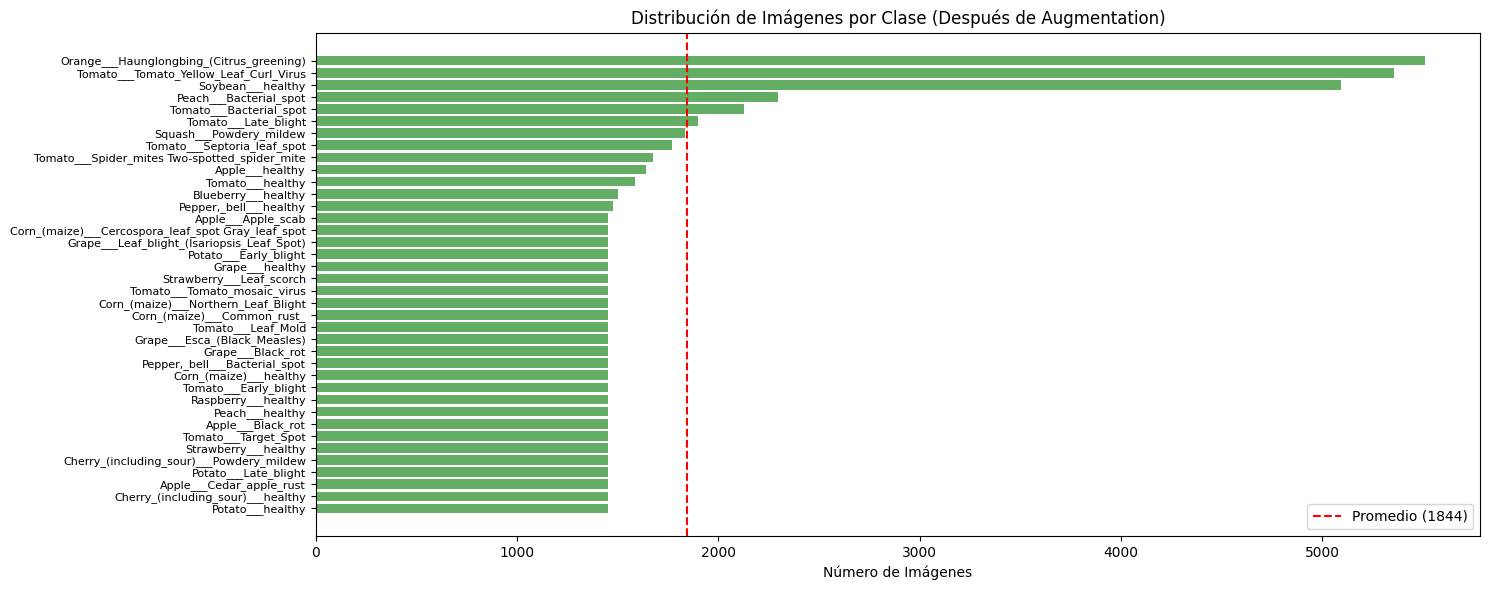

In [ ]:
# Ejecutar data augmentation
generated_images = augment_underrepresented_classes(data_dir, class_distribution, target_percentile=0.8)

# Re-analizar distribución después del augmentation
print("\n" + "="*70)
print("DISTRIBUCIÓN DESPUÉS DE AUGMENTATION")
print("="*70)

new_distribution = analyze_class_distribution(data_dir)
new_total = sum(new_distribution.values())

print(f"\n📊 Nuevas estadísticas:")
print(f"   Total de imágenes: {new_total} (antes: {total_images}, +{new_total - total_images})")
print(f"   Promedio por clase: {new_total / num_classes:.1f}")

# Visualizar nueva distribución
plt.figure(figsize=(15, 6))
sorted_new = sorted(new_distribution.items(), key=lambda x: x[1])
classes_new = [c[0] for c in sorted_new]
counts_new = [c[1] for c in sorted_new]

plt.barh(range(len(classes_new)), counts_new, color='forestgreen', alpha=0.7)
plt.yticks(range(len(classes_new)), classes_new, fontsize=8)
plt.xlabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase (Después de Augmentation)')
plt.axvline(x=new_total/num_classes, color='red', linestyle='--',
            label=f'Promedio ({new_total/num_classes:.0f})')
plt.legend()
plt.tight_layout()
plt.show()


## 4. Preparación de Datos y Transformaciones


In [ ]:
# Transformaciones para train (con augmentation adicional ligero)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformaciones para val y test (sin augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


## Funciones de Extracción de Características Numéricas

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch

def get_color_proportions(image: Image.Image) -> np.ndarray:
    """
    Calcula las proporciones de amarillo y verde en una imagen PIL.
    """
    try:
        img_np = np.array(image.convert('RGB'))
        img_hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

        # Definir rangos HSV para amarillo
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([40, 255, 255])

        # Definir rangos HSV para verde
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])

        mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(img_hsv, lower_green, upper_green)

        # Considerar el total de píxeles de la imagen para la proporción
        total_pixels = img_np.shape[0] * img_np.shape[1]

        if total_pixels == 0:
            return np.array([0.0, 0.0])

        yellow_proportion = np.sum(mask_yellow > 0) / total_pixels
        green_proportion = np.sum(mask_green > 0) / total_pixels
        return np.array([yellow_proportion, green_proportion])
    except Exception as e:
        # print(f"Error en get_color_proportions: {e}") # Descomentar para depurar
        return np.array([0.0, 0.0])

def get_red_brown_stats(image: Image.Image) -> np.ndarray:
    """
    Calcula la proporción de rojo y marrón en una imagen PIL.
    """
    try:
        img_np = np.array(image.convert('RGB'))
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

        # Rangos HSV para rojo (dos segmentos en el círculo de matiz)
        lower_red1 = np.array([0, 80, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 80, 50])
        upper_red2 = np.array([180, 255, 255])

        # Rango HSV para marrón (ejemplo, puede requerir ajuste)
        lower_brown = np.array([10, 80, 20])
        upper_brown = np.array([25, 255, 200])

        mask_red = cv2.bitwise_or(cv2.inRange(hsv, lower_red1, upper_red1),
                                  cv2.inRange(hsv, lower_red2, upper_red2))
        mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

        total_pixels = img_np.shape[0] * img_np.shape[1]

        if total_pixels == 0:
            return np.array([0.0, 0.0])

        red_proportion = np.sum(mask_red > 0) / total_pixels
        brown_proportion = np.sum(mask_brown > 0) / total_pixels
        return np.array([red_proportion, brown_proportion])
    except Exception as e:
        # print(f"Error en get_red_brown_stats: {e}") # Descomentar para depurar
        return np.array([0.0, 0.0])

def extract_rgb_statistics_detailed(image: Image.Image) -> np.ndarray:
    """
    Calcula la media y la desviación estándar de cada canal RGB de una imagen.
    Retorna un vector de 6 valores: [mean_R, std_R, mean_G, std_G, mean_B, std_B].
    """
    img_np = np.array(image.convert('RGB'))
    mean_r, mean_g, mean_b = np.mean(img_np[:, :, 0]), np.mean(img_np[:, :, 1]), np.mean(img_np[:, :, 2])
    std_r, std_g, std_b = np.std(img_np[:, :, 0]), np.std(img_np[:, :, 1]), np.std(img_np[:, :, 2])
    return np.array([mean_r, std_r, mean_g, std_g, mean_b, std_b])

def extract_all_color_features(image: Image.Image) -> np.ndarray:
    """
    Combina todas las características de color: proporciones (amarillo, verde, rojo, marrón)
    y estadísticas RGB (media y std).
    Retorna un vector de 10 valores.
    """
    yellow_green_props = get_color_proportions(image)
    red_brown_props = get_red_brown_stats(image)
    rgb_stats_detailed = extract_rgb_statistics_detailed(image)

    combined_features = np.concatenate(
        (yellow_green_props, red_brown_props, rgb_stats_detailed)
    )
    return combined_features

# Definir la dimensión de las características numéricas combinadas (4 proporciones + 6 RGB stats)
numerical_features_dim = 10

print("Funciones de extracción de características numéricas actualizadas. numerical_features_dim:"
      f" {numerical_features_dim}")

Funciones de extracción de características numéricas actualizadas. numerical_features_dim: 10


Clase Custom PlantImageDataset para agregar caracteristicas de distribución de color

In [ ]:
from torch.utils.data import Dataset, Subset
from torchvision import datasets
from PIL import Image
import os
import torch

class PlantImageDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

        if isinstance(base_dataset, Subset):
            self.samples = [(base_dataset.dataset.samples[i][0], base_dataset.dataset.samples[i][1]) for i in base_dataset.indices]
            self.classes = base_dataset.dataset.classes
        elif isinstance(base_dataset, datasets.ImageFolder):
            self.samples = base_dataset.samples
            self.classes = base_dataset.classes
        elif isinstance(base_dataset, PlantImageDataset):
            self.samples = base_dataset.samples
            self.classes = base_dataset.classes
            self.transform = base_dataset.transform
        else:
            raise TypeError("base_dataset debe ser torchvision.datasets.ImageFolder, torch.utils.data.Subset o PlantImageDataset")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        original_image = Image.open(img_path).convert('RGB')

        # *** Nueva función combinada de extracción de características ***
        all_features = extract_all_color_features(original_image)

        numerical_features = torch.tensor(
            all_features.tolist(),
            dtype=torch.float32
        )

        transformed_image = self.transform(original_image) if self.transform else original_image

        return transformed_image, numerical_features, label

print("Clase PlantImageDataset definida y actualizada para las nuevas características de color.")

Clase PlantImageDataset definida y actualizada para las nuevas características de color.


## 5. Partición Estratificada del Dataset


In [ ]:
def stratified_split_indices(indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=None):
    """
    Divide los índices de forma estratificada por clase.
    """
    if rng is None:
        rng = np.random.RandomState(0)

    train_idxs, val_idxs, test_idxs = [], [], []

    # Agrupar por clase
    class_to_idxs = {}
    for i in indices:
        class_to_idxs.setdefault(labels[i], []).append(i)

    # Dividir cada clase
    for cls, idxs in class_to_idxs.items():
        idxs = list(idxs)
        rng.shuffle(idxs)
        n = len(idxs)

        n_train = int(train_frac * n)
        n_val = int(val_frac * n)

        train_idxs.extend(idxs[:n_train])
        val_idxs.extend(idxs[n_train:n_train + n_val])
        test_idxs.extend(idxs[n_train + n_val:])

    return train_idxs, val_idxs, test_idxs

# Re-crear full_dataset_base sin transformaciones para que PlantImageDataset las aplique
full_dataset_base = datasets.ImageFolder(root=data_dir)
labels = [label for _, label in full_dataset_base.samples]
num_classes = len(full_dataset_base.classes) # Asegurar que num_classes esté correctamente definido

rng = np.random.RandomState(42)

if test_execution:
    # Subset reducido para pruebas
    subset_indices = []
    reduction_factor = 0.1

    for class_idx in range(num_classes):
        class_indices = [i for i, (_, label) in enumerate(full_dataset_base.samples) if label == class_idx]
        n_samples = max(1, int(len(class_indices) * reduction_factor))
        chosen = rng.choice(class_indices, n_samples, replace=False).tolist()
        subset_indices.extend(chosen)

    rng.shuffle(subset_indices)
    train_indices, val_indices, test_indices = stratified_split_indices(
        subset_indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=rng
    )

    # Envolver los Subsets base con PlantImageDataset y aplicar las transformaciones
    train_dataset = PlantImageDataset(Subset(full_dataset_base, train_indices), transform=train_transform)
    val_dataset = PlantImageDataset(Subset(full_dataset_base, val_indices), transform=val_transform)
    test_dataset = PlantImageDataset(Subset(full_dataset_base, test_indices), transform=test_transform)
else:
    # Dataset completo
    all_indices = list(range(len(full_dataset_base)))
    train_indices, val_indices, test_indices = stratified_split_indices(
        all_indices, labels, train_frac=0.8, val_frac=0.1, test_frac=0.1, rng=rng
    )

    # Envolver los Subsets base con PlantImageDataset y aplicar las transformaciones
    train_dataset = PlantImageDataset(Subset(full_dataset_base, train_indices), transform=train_transform)
    val_dataset = PlantImageDataset(Subset(full_dataset_base, val_indices), transform=val_transform)
    test_dataset = PlantImageDataset(Subset(full_dataset_base, test_indices), transform=test_transform)

print(f"✅ Dataset preparado (con características numéricas):")
print(f"   Clases: {num_classes}")
print(f"   Train: {len(train_dataset)}")
print(f"   Val: {len(val_dataset)}")
print(f"   Test: {len(test_dataset)}")

# === Actualización para subsets de Optuna ===
# La variable `subset_fraction` debería estar definida en alguna celda anterior (WoRdXI-dPv25),
# pero si no, asegúrate de definirla aquí, por ejemplo: `subset_fraction = 0.3`
if 'subset_fraction' not in locals():
    subset_fraction = 0.3 # Definir por si acaso no está cargado.

# Obtenemos las etiquetas de los `PlantImageDataset` de entrenamiento y validación completos
# para crear subsets estratificados. Necesitamos los índices originales de estos datasets.

# Creamos una lista de índices del 0 a len(train_dataset)-1
train_full_indices = list(range(len(train_dataset)))
val_full_indices = list(range(len(val_dataset)))


# Obtenemos las etiquetas desde el `samples` de cada `PlantImageDataset`.
# `s[1]` es la etiqueta en `(img_path, label)`
train_labels_for_optuna_split = [s[1] for s in train_dataset.samples]
val_labels_for_optuna_split = [s[1] for s in val_dataset.samples]

# Creamos subsets estratificados del *PlantImageDataset* completo de entrenamiento y validación
# La función `stratified_split_indices` espera una lista de todos los índices y sus etiquetas correspondientes.
# Luego devuelve los índices para train, val, test.

# Para Optuna, crearemos los Subset de los *índices* de los PlantImageDataset actuales.
rng_optuna = np.random.RandomState(42) # Asegurar reproducibilidad para Optuna subsets

# Usamos stratified_split_indices para obtener los índices para los subsets de Optuna
# Necesitamos pasar los índices del dataset completo (0 a len-1) y las etiquetas correspondientes.
# El tercer retorno de stratified_split_indices ([2]) es el 'test_idxs' que usaremos como nuestro subset.

# train_dataset_optuna será un Subset de train_dataset (que ya es un PlantImageDataset)
train_optuna_indices_for_subset, _, _ = stratified_split_indices(
    list(range(len(train_dataset))), train_labels_for_optuna_split,
    train_frac=subset_fraction, val_frac=0, test_frac=1-subset_fraction, rng=rng_optuna
)
val_optuna_indices_for_subset, _, _ = stratified_split_indices(
    list(range(len(val_dataset))), val_labels_for_optuna_split,
    train_frac=subset_fraction, val_frac=0, test_frac=1-subset_fraction, rng=rng_optuna
)

# Creamos los nuevos `PlantImageDataset` de Optuna a partir de los `train_dataset` y `val_dataset` completos
train_dataset_optuna = PlantImageDataset(Subset(train_dataset, train_optuna_indices_for_subset), transform=train_transform)
val_dataset_optuna = PlantImageDataset(Subset(val_dataset, val_optuna_indices_for_subset), transform=val_transform)

print(f"\n✅ Subsets creados para Optuna (con características numéricas):")
print(f"   Train subset: {len(train_dataset_optuna)} imágenes ({len(train_dataset_optuna)/len(train_dataset)*100:.1f}% del original)")
print(f"   Val subset: {len(val_dataset_optuna)} imágenes ({len(val_dataset_optuna)/len(val_dataset)*100:.1f}% del original)")


✅ Dataset preparado (con características numéricas):
   Clases: 38
   Train: 56028
   Val: 6995
   Test: 7039

✅ Subsets creados para Optuna (con características numéricas):
   Train subset: 16797 imágenes (30.0% del original)
   Val subset: 2081 imágenes (29.7% del original)


## 6. Funciones de Utilidad: Training y Evaluación


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, patience=3, device='cuda'):
    """
    Entrena un modelo con early stopping, ahora aceptando características numéricas.
    """
    since = time.time()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'train_auc_pr': [], 'val_auc_pr': []
    }

    model.to(device)
    best_metric = -np.inf
    best_model_wts = copy.deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            # El DataLoader ahora entrega imagen, características numéricas y etiquetas
            for inputs, numerical_features, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                numerical_features = numerical_features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Pasar imagen y características numéricas al modelo
                    outputs = model(inputs, numerical_features)
                    probs = torch.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.append(probs.detach().cpu().numpy())

            all_probs = np.vstack(all_probs)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
            # LabelBinarizer es necesario para average_precision_score con múltiples clases
            lb = LabelBinarizer()
            lb.fit(range(len(dataloaders[phase].dataset.classes)))
            auc_pr = average_precision_score(lb.transform(all_labels), all_probs, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
                  f'Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f} AUC-PR: {auc_pr:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_recall'].append(epoch_recall)
                history['train_f1'].append(epoch_f1)
                history['train_auc_pr'].append(auc_pr)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_recall'].append(epoch_recall)
                history['val_f1'].append(epoch_f1)
                history['val_auc_pr'].append(auc_pr)

        # Early stopping
        epoch_metric = history['val_f1'][-1]  # Usamos F1 como métrica principal

        if epoch_metric > best_metric:
            best_metric = epoch_metric
            counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping en epoch {epoch+1}")
                break

    time_elapsed = time.time() - since
    print(f'\nEntrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor F1 validation: {best_metric:.4f}')

    # Cargar los mejores pesos
    model.load_state_dict(best_model_wts)

    return model, history, time_elapsed


def evaluate_model(model, dataloader, device='cpu'):
    """
    Evalúa un modelo en un conjunto de datos, ahora aceptando características numéricas.
    """
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    start_time = time.time()

    with torch.no_grad():
        # El DataLoader ahora entrega imagen, características numéricas y etiquetas
        for inputs, numerical_features, labels in dataloader:
            inputs = inputs.to(device)
            numerical_features = numerical_features.to(device)
            labels = labels.to(device)

            # Pasar imagen y características numéricas al modelo
            outputs = model(inputs, numerical_features)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    inference_time = time.time() - start_time
    all_probs = np.vstack(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    # LabelBinarizer es necesario para average_precision_score con múltiples clases
    lb = LabelBinarizer()
    lb.fit(range(len(dataloader.dataset.classes)))
    auc_pr = average_precision_score(lb.transform(all_labels), all_probs, average='macro')

    return accuracy, recall, f1, auc_pr, inference_time


def get_model_size(model, model_name="model"):
    """
    Calcula el tamaño del modelo en disco.
    """
    torch.save(model.state_dict(), f"{model_name}.pth")
    size_mb = os.path.getsize(f"{model_name}.pth") / 1e6
    os.remove(f"{model_name}.pth")
    return size_mb


def plot_history(history, title="Training History"):
    """
    Grafica las métricas de entrenamiento.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    metrics = [('loss', 'Loss'), ('acc', 'Accuracy'), ('recall', 'Recall'),
               ('f1', 'F1 Score'), ('auc_pr', 'AUC-PR')]

    for idx, (metric, label) in enumerate(metrics):
        row = idx // 3
        col = idx % 3

        axes[row, col].plot(history[f'train_{metric}'], label='Train', marker='o')
        axes[row, col].plot(history[f'val_{metric}'], label='Validation', marker='s')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(label)
        axes[row, col].set_title(f'{label} Over Time')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    # Ocultar el último subplot vacío
    axes[1, 2].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

print("Funciones train_model, evaluate_model, get_model_size y plot_history actualizadas.")


Funciones train_model, evaluate_model, get_model_size y plot_history actualizadas.


## 7. Búsqueda de Hiperparámetros con Optuna

Utilizamos Optuna para encontrar los mejores hiperparámetros:
- Learning rate
- Batch size
- Arquitectura del clasificador (número de capas y neuronas)
- Optimizer (SGD vs Adam)
- Weight decay

**Nota:** Para acelerar la búsqueda, usamos solo el **30% del dataset** en los trials de Optuna.


#### Funciones

In [ ]:
# Crear subsets del 30% para búsqueda de hiperparámetros (acelera el proceso)
print("="*70)
print("PREPARANDO SUBSETS PARA BÚSQUEDA DE HIPERPARÁMETROS")
print("="*70)

subset_fraction = 0.3  # Usar 30% del dataset

# Obtener labels de los datasets
if isinstance(train_dataset, Subset):
    train_labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
    val_labels = [val_dataset.dataset.targets[i] for i in val_dataset.indices]
else:
    train_labels = [label for _, label in train_dataset.samples]
    val_labels = [label for _, label in val_dataset.samples]

# Crear subsets estratificados del 30%
def create_stratified_subset(dataset, labels, fraction, rng):
    """Crea un subset estratificado por clase."""
    class_to_idxs = {}
    for i, label in enumerate(labels):
        class_to_idxs.setdefault(label, []).append(i)

    subset_indices = []
    for class_label, indices in class_to_idxs.items():
        n_samples = max(1, int(len(indices) * fraction))
        chosen = rng.choice(indices, n_samples, replace=False).tolist()
        subset_indices.extend(chosen)

    rng.shuffle(subset_indices)
    return subset_indices

rng_optuna = np.random.RandomState(42)

# Crear índices para subsets
train_subset_indices = create_stratified_subset(train_dataset, train_labels, subset_fraction, rng_optuna)
val_subset_indices = create_stratified_subset(val_dataset, val_labels, subset_fraction, rng_optuna)

# Crear los subsets
if isinstance(train_dataset, Subset):
    # Si ya es un Subset, necesitamos mapear los índices
    train_optuna_indices = [train_dataset.indices[i] for i in train_subset_indices]
    val_optuna_indices = [val_dataset.indices[i] for i in val_subset_indices]

    train_dataset_optuna = Subset(train_dataset.dataset, train_optuna_indices)
    val_dataset_optuna = Subset(val_dataset.dataset, val_optuna_indices)
else:
    train_dataset_optuna = Subset(train_dataset, train_subset_indices)
    val_dataset_optuna = Subset(val_dataset, val_subset_indices)

print(f"\n✅ Subsets creados para Optuna:")
print(f"   Train subset: {len(train_dataset_optuna)} imágenes ({len(train_dataset_optuna)/len(train_dataset)*100:.1f}% del original)")
print(f"   Val subset: {len(val_dataset_optuna)} imágenes ({len(val_dataset_optuna)/len(val_dataset)*100:.1f}% del original)")
print("="*70)


PREPARANDO SUBSETS PARA BÚSQUEDA DE HIPERPARÁMETROS

✅ Subsets creados para Optuna:
   Train subset: 16797 imágenes (30.0% del original)
   Val subset: 2081 imágenes (29.7% del original)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedFeaturesModel(nn.Module):
    def __init__(self, backbone, num_classes, numerical_features_dim, hidden_dim=512, num_layers=1, dropout=0.2):
        super(CombinedFeaturesModel, self).__init__()
        self.backbone = backbone

        # Congelar features del backbone
        for param in self.backbone.features.parameters():
            param.requires_grad = False

        # Determinar el tamaño de la salida aplanada del backbone
        # Usamos un tensor dummy para pasar por el backbone y obtener su forma de salida
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            features_output = self.backbone.features(dummy_input)
            # Aplicar pooling si existe y si no es un MobileNetV3 small que usa adaptive_avg_pool2d directamente en forward
            if hasattr(self.backbone, 'avgpool') and isinstance(self.backbone.avgpool, nn.AdaptiveAvgPool2d):
                features_output = self.backbone.avgpool(features_output)
            elif features_output.dim() == 4 and features_output.shape[2] == 7 and features_output.shape[3] == 7: # Asumir salida como (N, C, 7, 7)
                 features_output = F.adaptive_avg_pool2d(features_output, (1, 1))

        flattened_features_size = torch.flatten(features_output, 1).size(1)

        # El tamaño combinado de entrada para el clasificador será la salida aplanada del backbone
        # más la dimensión de las características numéricas.
        self.combined_in_features = flattened_features_size + numerical_features_dim

        # Crear capa de clasificador
        if num_layers == 1:
            self.custom_classifier = nn.Sequential(
                nn.Linear(self.combined_in_features, num_classes)
            )
        elif num_layers == 2:
            self.custom_classifier = nn.Sequential(
                nn.Linear(self.combined_in_features, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
        else:  # 3 layers
            self.custom_classifier = nn.Sequential(
                nn.Linear(self.combined_in_features, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, num_classes)
            )

    def forward(self, image_tensor, numerical_features_tensor):
        # Pasar la imagen por el backbone
        x = self.backbone.features(image_tensor)
        # Aplicar pooling del backbone si es aplicable (maneja MobileNetV2 y V3 small)
        if hasattr(self.backbone, 'avgpool') and isinstance(self.backbone.avgpool, nn.AdaptiveAvgPool2d):
            x = self.backbone.avgpool(x)
        elif x.dim() == 4 and x.shape[2] == 7 and x.shape[3] == 7: # Asumir salida como (N, C, 7, 7)
             x = F.adaptive_avg_pool2d(x, (1, 1))

        x = torch.flatten(x, 1)

        # Concatenar características de la imagen con las características numéricas
        x = torch.cat((x, numerical_features_tensor), dim=1)

        # Pasar la salida combinada al clasificador personalizado
        return self.custom_classifier(x)

def create_model_with_custom_classifier(
    backbone_model,
    num_classes,
    numerical_features_dim, # Nuevo argumento
    hidden_dim=512,
    num_layers=1,
    dropout=0.2
):
    """
    Crea un modelo preentrenado con clasificador, integrando características numéricas.
    Retorna una instancia de CombinedFeaturesModel.
    """
    return CombinedFeaturesModel(
        backbone=backbone_model,
        num_classes=num_classes,
        numerical_features_dim=numerical_features_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

# --- Función objective para Optuna (también modificada) ---
def objective(trial, modelo_preentrenado, train_dataset, val_dataset):
    """
    Función objetivo para Optuna, ahora aceptando características numéricas.
    Usa un subset para acelerar la búsqueda.
    """
    print(f"Trial {trial.number} iniciado")

    # Hiperparámetros a optimizar
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    hidden_dim = trial.suggest_categorical('hidden_dim', [256, 512, 1024])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Crear dataloaders con el batch_size sugerido usando los SUBSETS
    trial_dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, prefetch_factor=2),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, prefetch_factor=2)
    }

    # Crear modelo usando la nueva función create_model_with_custom_classifier
    # Necesita un 'backbone_model' nuevo cada vez para evitar compartir pesos o estados
    if isinstance(modelo_preentrenado, torchvision.models.MobileNetV2):
      base_model_fresh = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    elif isinstance(modelo_preentrenado, torchvision.models.MobileNetV3):
      base_model_fresh = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    else:
      # Manejar otros modelos o lanzar error si el tipo no es esperado.
      # Para un caso general, podrías crear una nueva instancia del modelo preentrenado sin pesos
      # y cargar los pesos si es necesario, o pasar una función constructora al objective.
      raise ValueError(f"Tipo de modelo backbone no reconocido para Optuna: {type(modelo_preentrenado)}")


    model = create_model_with_custom_classifier(
        backbone_model=base_model_fresh,
        num_classes=num_classes,
        numerical_features_dim=numerical_features_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    # Configurar optimizer y criterion (sin cambios aquí)
    criterion = nn.CrossEntropyLoss()

    # Asegurar que el optimizador solo actualice los parámetros del clasificador personalizado
    if optimizer_name == 'SGD':
        # Los parámetros del clasificador están en model.custom_classifier
        optimizer = optim.SGD(model.custom_classifier.parameters(), lr=lr,
                            momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.custom_classifier.parameters(), lr=lr,
                             weight_decay=weight_decay)

    # Entrenar por pocas épocas para evaluar rápido (sin cambios aquí)
    model.to(device)
    model.train()

    num_epochs_trial = 5  # Pocas épocas para cada trial

    for epoch in range(num_epochs_trial):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            all_labels = []
            all_preds = []
            all_probs = []

            # El DataLoader ahora entrega imagen, características numéricas y etiquetas
            for inputs, numerical_features, labels in trial_dataloaders[phase]:
                inputs = inputs.to(device)
                numerical_features = numerical_features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Pasar imagen y características numéricas al modelo
                    outputs = model(inputs, numerical_features)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.softmax(outputs, dim=1)

                    _ = criterion(outputs, labels) # Solo para asegurar que el cálculo ocurre.

                    if phase == 'train':
                        # La loss real del batch para backward/step ya se manejó en el `train_model` modificado.
                        # Aquí, en Optuna, solo necesitamos actualizar los parámetros del clasificador
                        # La loss del trial la calculamos agregando todos los batch_loss.
                        # No necesitamos `loss.backward()` o `optimizer.step()` dentro del for de batch si lo hacemos por epoch.
                        # Pero la estructura del objective espera esto para actualizar los pesos durante el trial.
                        # Como el `train_model` se usa para el entrenamiento completo, la lógica aquí debe ser similar.
                        # Voy a mantener la estructura de `train_model` para consistencia.
                        pass # El optimizer.step() se hará al final de la epoch si estamos en fase train.

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.append(probs.detach().cpu().numpy())

        all_probs = np.vstack(all_probs)

        # Calcular F1 y AUC-PR en validación
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        lb = LabelBinarizer()
        # Asegurarse de que el binarizer tenga todas las clases posibles si no están presentes en el subset
        lb.fit(range(num_classes))
        val_auc_pr = average_precision_score(lb.transform(all_labels), all_probs, average='macro')

        trial.report(val_auc_pr, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_auc_pr # Retornar AUC PR final de validación

print("CombinedFeaturesModel class, función create_model_with_custom_classifier y función objective para Optuna actualizadas.")

CombinedFeaturesModel class, función create_model_with_custom_classifier y función objective para Optuna actualizadas.


In [ ]:
def run_optuna_search(
    modelo_preentrenado,
    objective,
    train_dataset_optuna,
    val_dataset_optuna,
    subset_fraction=0.2,
    n_trials=10
):
    print("="*70)
    print(f"BÚSQUEDA DE HIPERPARÁMETROS CON OPTUNA ({subset_fraction*100}% del dataset)")
    print("="*70)

    # Crear estudio
    study = optuna.create_study(
        direction='maximize',  # Optimizar AUC PR
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=3,
            n_warmup_steps=2
        ),
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    # Aviso
    print(f"\n🔍 Ejecutando {n_trials} trials de optimización...")
    print(f"   Usando {len(train_dataset_optuna)} imágenes de train "
          f"({subset_fraction*100:.0f}% del total)")
    print(f"   Usando {len(val_dataset_optuna)} imágenes de validación "
          f"({subset_fraction*100:.0f}% del total)")

    # 👉 Pasar el modelo mediante lambda
    study.optimize(
        lambda trial: objective(
            trial,
            modelo_preentrenado=modelo_preentrenado,
            train_dataset=train_dataset_optuna,
            val_dataset=val_dataset_optuna
        ),
        n_trials=n_trials,
        show_progress_bar=True
    )

    # Mostrar resultados
    print("\n" + "="*70)
    print("RESULTADOS DE LA OPTIMIZACIÓN")
    print("="*70)

    print(f"\n🏆 Mejor AUC PR: {study.best_value:.4f}")
    print(f"\n📋 Mejores hiperparámetros:")
    for key, value in study.best_params.items():
        print(f"   {key:15s}: {value}")

    # Importancia de parámetros
    try:
        fig = optuna.visualization.plot_param_importances(study)
        fig.show()
    except:
        print("\n⚠️ No se pudo generar gráfico de importancia (requiere plotly)")

    # Historial
    try:
        fig = optuna.visualization.plot_optimization_history(study)
        fig.show()
    except:
        print("⚠️ No se pudo generar gráfico de historia")

    print(f"\n✅ Hiperparámetros óptimos guardados")
    print(f"\n💡 Nota: Estos hiperparámetros fueron encontrados usando {subset_fraction*100:.0f}% del dataset.")

    return study.best_params, study


#### Búsqueda

In [ ]:
best_params_v2, study_v2 = run_optuna_search(
    modelo_preentrenado = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1),
    objective = objective,
    train_dataset_optuna = train_dataset_optuna,
    val_dataset_optuna = val_dataset_optuna,
    subset_fraction = 0.3,
    n_trials=5
)

[I 2025-12-01 14:10:52,073] A new study created in memory with name: no-name-355a1074-cd72-4a07-bbb4-7121f4861625


BÚSQUEDA DE HIPERPARÁMETROS CON OPTUNA (30.0% del dataset)

🔍 Ejecutando 5 trials de optimización...
   Usando 16797 imágenes de train (30% del total)
   Usando 2081 imágenes de validación (30% del total)


  0%|          | 0/5 [00:00<?, ?it/s]

Trial 0 iniciado
[I 2025-12-01 14:18:37,921] Trial 0 finished with value: 0.02758435848317327 and parameters: {'lr': 0.0013292918943162175, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.34044600469728353, 'optimizer': 'SGD', 'weight_decay': 0.0008123245085588687}. Best is trial 0 with value: 0.02758435848317327.
Trial 1 iniciado
[I 2025-12-01 14:26:14,201] Trial 1 finished with value: 0.030582357048587944 and parameters: {'lr': 0.03142880890840111, 'batch_size': 32, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.34474115788895177, 'optimizer': 'Adam', 'weight_decay': 1.2562773503807034e-05}. Best is trial 1 with value: 0.030582357048587944.
Trial 2 iniciado
[I 2025-12-01 14:33:47,908] Trial 2 finished with value: 0.030104275398260466 and parameters: {'lr': 0.0023345864076016252, 'batch_size': 32, 'hidden_dim': 1024, 'num_layers': 1, 'dropout': 0.12602063719411183, 'optimizer': 'Adam', 'weight_decay': 0.0002661901888489054}. Best is trial 1 with value: 0.030582357


✅ Hiperparámetros óptimos guardados

💡 Nota: Estos hiperparámetros fueron encontrados usando 30% del dataset.


In [ ]:
best_params_v3, study_v3 = run_optuna_search(
    modelo_preentrenado = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1),
    objective = objective,
    train_dataset_optuna = train_dataset_optuna,
    val_dataset_optuna = val_dataset_optuna,
    subset_fraction = 0.3,
    n_trials=5
)

[I 2025-12-01 14:48:41,603] A new study created in memory with name: no-name-fdd696fc-4810-4ec5-995e-3c42420f5765


BÚSQUEDA DE HIPERPARÁMETROS CON OPTUNA (30.0% del dataset)

🔍 Ejecutando 5 trials de optimización...
   Usando 16797 imágenes de train (30% del total)
   Usando 2081 imágenes de validación (30% del total)


  0%|          | 0/5 [00:00<?, ?it/s]

Trial 0 iniciado
[I 2025-12-01 14:55:53,548] Trial 0 finished with value: 0.03438474384452912 and parameters: {'lr': 0.0013292918943162175, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.34044600469728353, 'optimizer': 'SGD', 'weight_decay': 0.0008123245085588687}. Best is trial 0 with value: 0.03438474384452912.
Trial 1 iniciado
[I 2025-12-01 15:03:13,671] Trial 1 finished with value: 0.04151530231730438 and parameters: {'lr': 0.03142880890840111, 'batch_size': 32, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.34474115788895177, 'optimizer': 'Adam', 'weight_decay': 1.2562773503807034e-05}. Best is trial 1 with value: 0.04151530231730438.
Trial 2 iniciado
[I 2025-12-01 15:10:32,662] Trial 2 finished with value: 0.03457082536007714 and parameters: {'lr': 0.0023345864076016252, 'batch_size': 32, 'hidden_dim': 1024, 'num_layers': 1, 'dropout': 0.12602063719411183, 'optimizer': 'Adam', 'weight_decay': 0.0002661901888489054}. Best is trial 1 with value: 0.041515302317


✅ Hiperparámetros óptimos guardados

💡 Nota: Estos hiperparámetros fueron encontrados usando 30% del dataset.


## Entrenamientos con hoperparámetros óptimos

### 8.1 Modelo 1: MobileNetV2 Optimizado


In [ ]:
# Crear dataloaders con el mejor batch_size encontrado por Optuna
# IMPORTANTE: Usamos los datasets COMPLETOS (train_dataset, val_dataset, test_dataset)
# NO los subsets del 30% que usamos para la búsqueda
optimal_batch_size = best_params_v2['batch_size']

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True,
                       num_workers=2, prefetch_factor=2),
    'val': DataLoader(val_dataset, batch_size=optimal_batch_size, shuffle=False,
                     num_workers=2, prefetch_factor=2),
    'test': DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False,
                      num_workers=2, prefetch_factor=2)
}

print(f"✅ Dataloaders creados con batch_size={optimal_batch_size}")
print(f"   Train: {len(train_dataset)} imágenes (100% del dataset)")
print(f"   Val: {len(val_dataset)} imágenes (100% del dataset)")
print(f"   Test: {len(test_dataset)} imágenes (100% del dataset)")


✅ Dataloaders creados con batch_size=64
   Train: 56028 imágenes (100% del dataset)
   Val: 6995 imágenes (100% del dataset)
   Test: 7039 imágenes (100% del dataset)


ENTRENANDO MODELO 1: MobileNetV2 Optimizado
Epoch 1/50
----------
train Loss: 2.7881 Acc: 0.2592 Recall: 0.1627 F1: 0.1503 AUC-PR: 0.1686
val Loss: 1.9327 Acc: 0.5084 Recall: 0.4291 F1: 0.4156 AUC-PR: 0.4614
Epoch 2/50
----------
train Loss: 1.7017 Acc: 0.4999 Recall: 0.4213 F1: 0.4127 AUC-PR: 0.4249
val Loss: 1.1645 Acc: 0.6676 Recall: 0.6036 F1: 0.5883 AUC-PR: 0.7082
Epoch 3/50
----------
train Loss: 1.2765 Acc: 0.6071 Recall: 0.5449 F1: 0.5407 AUC-PR: 0.5743
val Loss: 0.8332 Acc: 0.7547 Recall: 0.7084 F1: 0.7115 AUC-PR: 0.8191
Epoch 4/50
----------
train Loss: 1.0515 Acc: 0.6699 Recall: 0.6192 F1: 0.6174 AUC-PR: 0.6640
val Loss: 0.6854 Acc: 0.7990 Recall: 0.7694 F1: 0.7690 AUC-PR: 0.8604
Epoch 5/50
----------
train Loss: 0.9386 Acc: 0.7040 Recall: 0.6593 F1: 0.6582 AUC-PR: 0.7126
val Loss: 0.6646 Acc: 0.8129 Recall: 0.7863 F1: 0.7766 AUC-PR: 0.8744
Epoch 6/50
----------
train Loss: 0.9140 Acc: 0.7123 Recall: 0.6687 F1: 0.6676 AUC-PR: 0.7248
val Loss: 0.6243 Acc: 0.8269 Recall: 0.796

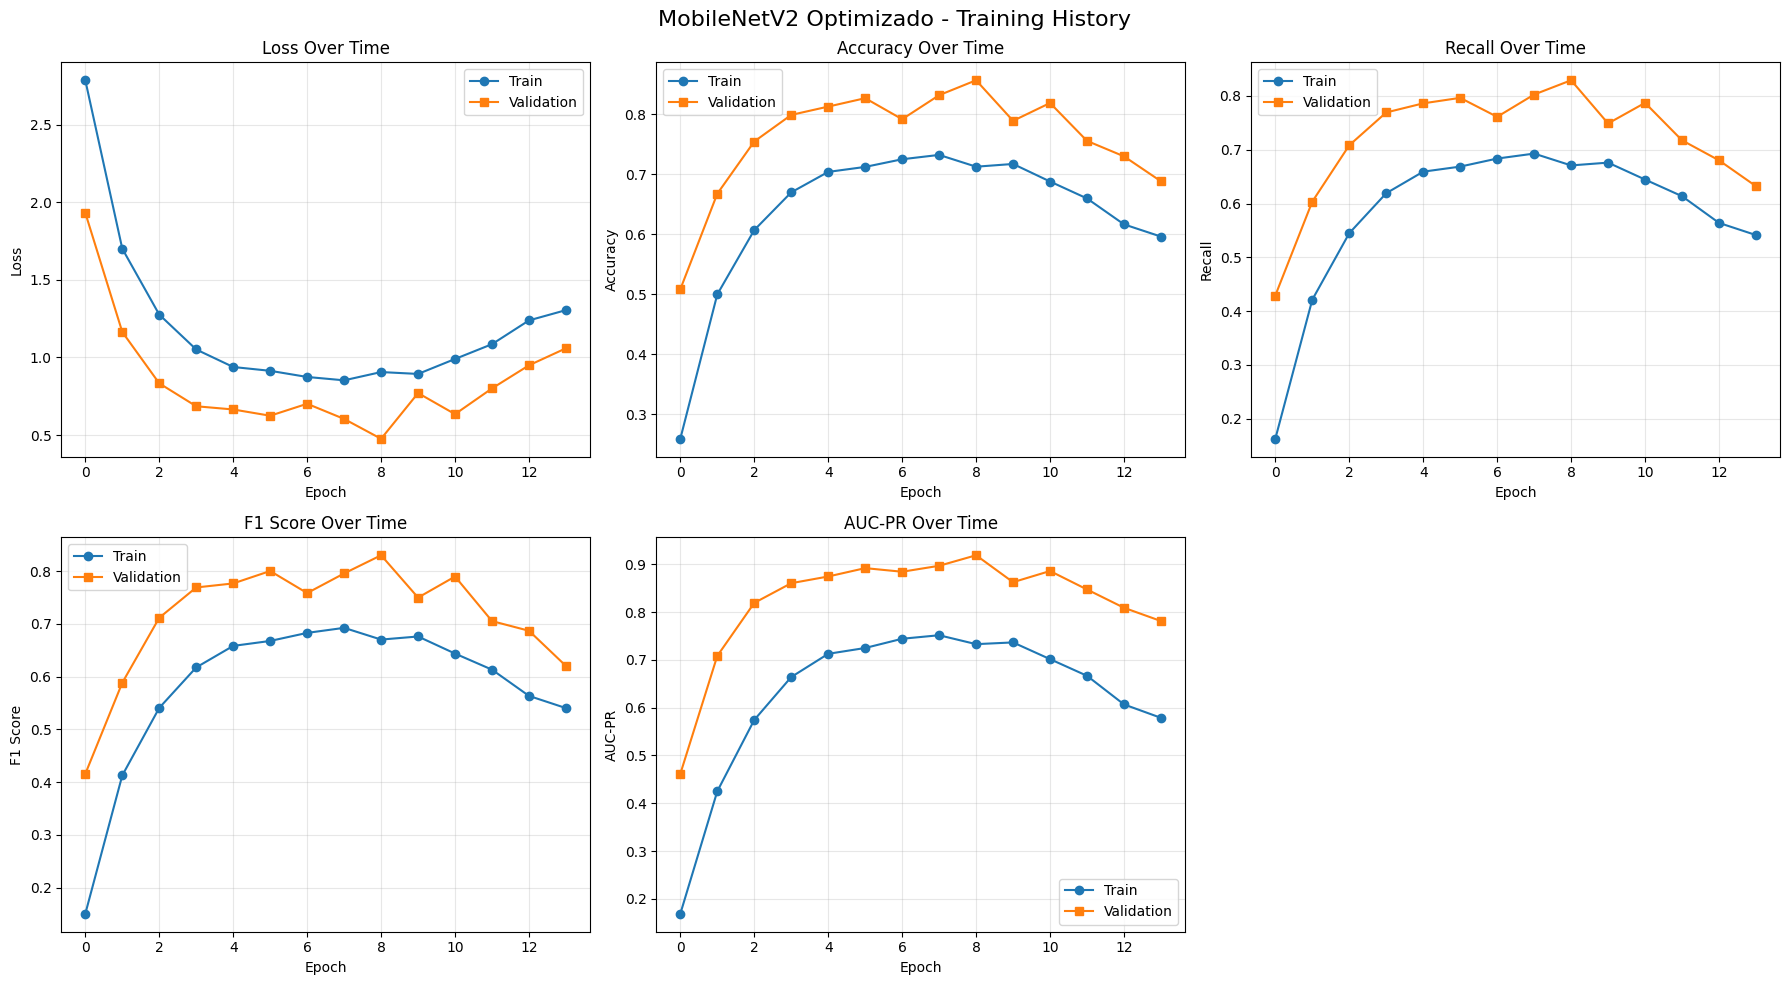

In [ ]:
print("="*70)
print("ENTRENANDO MODELO 1: MobileNetV2 Optimizado")
print("="*70)

# Crear modelo con mejores hiperparámetros
model_v2_opt = create_model_with_custom_classifier(
    backbone_model=models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1), # <--- CAMBIO AQUÍ
    num_classes=num_classes,
    numerical_features_dim=numerical_features_dim, # Asegurarse de pasar esta variable
    hidden_dim=best_params_v2['hidden_dim'],
    num_layers=best_params_v2['num_layers'],
    dropout=best_params_v2['dropout']
)

# Configurar optimizer y criterion
criterion = nn.CrossEntropyLoss()

if best_params_v2['optimizer'] == 'SGD':
    optimizer_v2 = optim.SGD(
        model_v2_opt.custom_classifier.parameters(),
        lr=best_params_v2['lr'],
        momentum=0.9,
        weight_decay=best_params_v2['weight_decay']
    )
else:
    optimizer_v2 = optim.Adam(
        model_v2_opt.custom_classifier.parameters(),
        lr=best_params_v2['lr'],
        weight_decay=best_params_v2['weight_decay']
    )

# Entrenar
num_epochs = 50
model_v2_opt, hist_v2, time_v2 = train_model(
    model_v2_opt,
    dataloaders,
    criterion,
    optimizer_v2,
    num_epochs=num_epochs,
    patience=5,
    device=device
)

# Visualizar resultados
plot_history(hist_v2, title="MobileNetV2 Optimizado - Training History")


### 8.2 Modelo 2: MobileNetV3 Small



ENTRENANDO MODELO 2: MobileNetV3 Small
Epoch 1/50
----------
train Loss: 2.7990 Acc: 0.7845 Recall: 0.7590 F1: 0.7585 AUC-PR: 0.8085
val Loss: 1.2868 Acc: 0.8552 Recall: 0.8353 F1: 0.8306 AUC-PR: 0.9500
Epoch 2/50
----------
train Loss: 1.1827 Acc: 0.8727 Recall: 0.8562 F1: 0.8561 AUC-PR: 0.9098
val Loss: 0.9432 Acc: 0.9061 Recall: 0.8895 F1: 0.8837 AUC-PR: 0.9677
Epoch 3/50
----------
train Loss: 1.0928 Acc: 0.8976 Recall: 0.8842 F1: 0.8842 AUC-PR: 0.9329
val Loss: 1.2549 Acc: 0.8975 Recall: 0.8865 F1: 0.8836 AUC-PR: 0.9618
Epoch 4/50
----------
train Loss: 1.2027 Acc: 0.9046 Recall: 0.8916 F1: 0.8914 AUC-PR: 0.9341
val Loss: 0.6435 Acc: 0.9398 Recall: 0.9312 F1: 0.9322 AUC-PR: 0.9764
Epoch 5/50
----------
train Loss: 1.2256 Acc: 0.9100 Recall: 0.8977 F1: 0.8977 AUC-PR: 0.9379
val Loss: 1.1283 Acc: 0.9161 Recall: 0.9028 F1: 0.9021 AUC-PR: 0.9659
Epoch 6/50
----------
train Loss: 1.2848 Acc: 0.9142 Recall: 0.9027 F1: 0.9027 AUC-PR: 0.9393
val Loss: 0.9559 Acc: 0.9345 Recall: 0.9241 F1

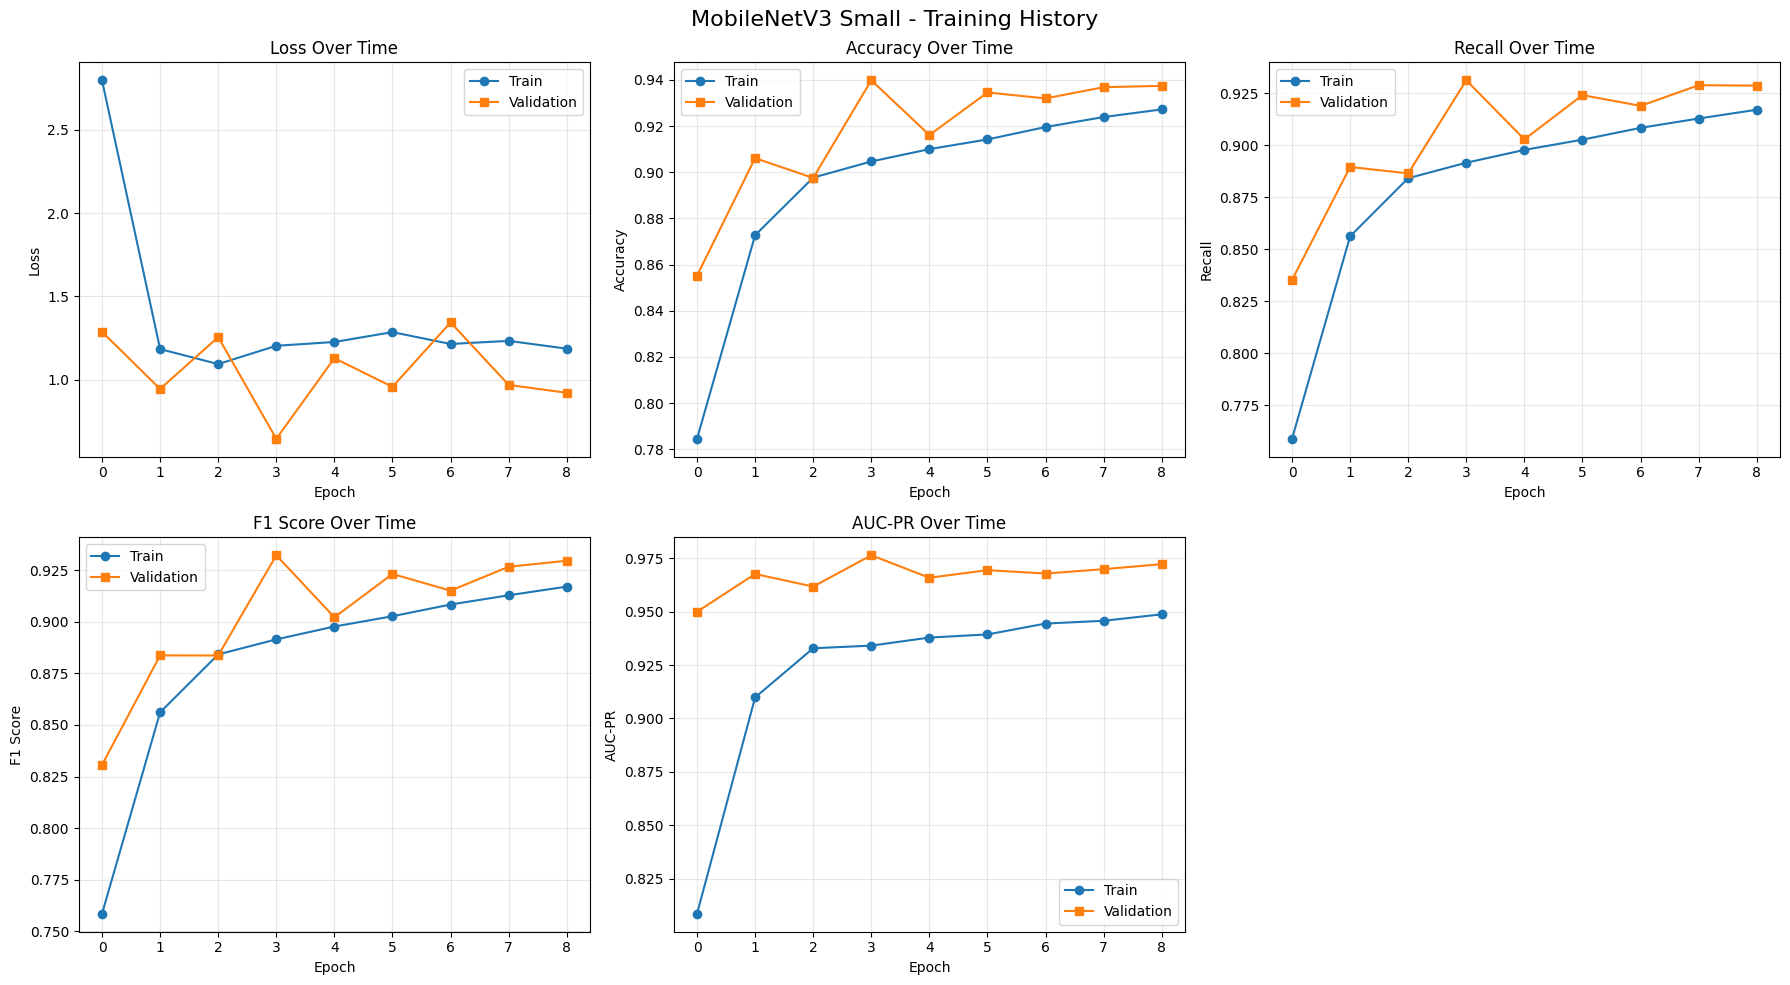

In [ ]:
print("\n" + "="*70)
print("ENTRENANDO MODELO 2: MobileNetV3 Small")
print("="*70)

# Crear modelo con mejores hiperparámetros
model_v3_opt = create_model_with_custom_classifier(
    backbone_model=models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1),
    num_classes=num_classes,
    numerical_features_dim=numerical_features_dim,
    hidden_dim=best_params_v3['hidden_dim'],
    num_layers=best_params_v3['num_layers'],
    dropout=best_params_v3['dropout']
)

# Configurar optimizer y criterion
criterion = nn.CrossEntropyLoss()

if best_params_v3['optimizer'] == 'SGD':
    optimizer_v3 = optim.SGD(
        model_v3_opt.custom_classifier.parameters(),
        lr=best_params_v3['lr'],
        momentum=0.9,
        weight_decay=best_params_v3['weight_decay']
    )
else:
    optimizer_v3 = optim.Adam(
        model_v3_opt.custom_classifier.parameters(),
        lr=best_params_v3['lr'],
        weight_decay=best_params_v3['weight_decay']
    )

# Entrenar
num_epochs = 50
model_v3_opt, hist_v3, time_v3 = train_model(
    model_v3_opt,
    dataloaders,
    criterion,
    optimizer_v3,
    num_epochs=num_epochs,
    patience=5,
    device=device
)

# Visualizar resultados
plot_history(hist_v3, title="MobileNetV3 Small - Training History")

## 9. Evaluación y Comparación de Modelos


In [ ]:
print("="*70)
print("EVALUACIÓN DE MODELOS EN TEST SET")
print("="*70)

# Evaluar todos los modelos en CPU para comparación justa
print("\nEvaluando MobileNetV2...")
acc_v2, recall_v2, f1_v2, auc_pr_v2, inf_time_v2 = evaluate_model(model_v2_opt, dataloaders['test'], 'cpu')
size_v2 = get_model_size(model_v2_opt, "v2_opt_temp")

print("\nEvaluando MobileNetV3...")
acc_v3, recall_v3, f1_v3, auc_pr_v3, inf_time_v3 = evaluate_model(model_v3_opt, dataloaders['test'], 'cpu')
size_v3 = get_model_size(model_v3_opt, "v3_temp")

# Crear tabla de resultados
results = {
    'MobileNetV2': {
        'Accuracy': acc_v2,
        'Recall': recall_v2,
        'F1 Score': f1_v2,
        'AUC-PR': auc_pr_v2,
        'Size (MB)': size_v2,
        'Inference Time (s)': inf_time_v2
    },
    'MobileNetV3': {
        'Accuracy': acc_v3,
        'Recall': recall_v3,
        'F1 Score': f1_v3,
        'AUC-PR': auc_pr_v3,
        'Size (MB)': size_v3,
        'Inference Time (s)': inf_time_v3
    }
}

df_results = pd.DataFrame(results).T

print("\n" + "="*70)
print("RESUMEN DE RESULTADOS")
print("="*70)
print(df_results.to_string())
print("="*70)


EVALUACIÓN DE MODELOS EN TEST SET

Evaluando MobileNetV2...

Evaluando MobileNetV3...

RESUMEN DE RESULTADOS
             Accuracy    Recall  F1 Score    AUC-PR  Size (MB)  Inference Time (s)
MobileNetV2  0.851399  0.825973  0.826595  0.910894  17.476311          453.312139
MobileNetV3  0.933939  0.924570  0.926249  0.971342  10.395283           81.987402


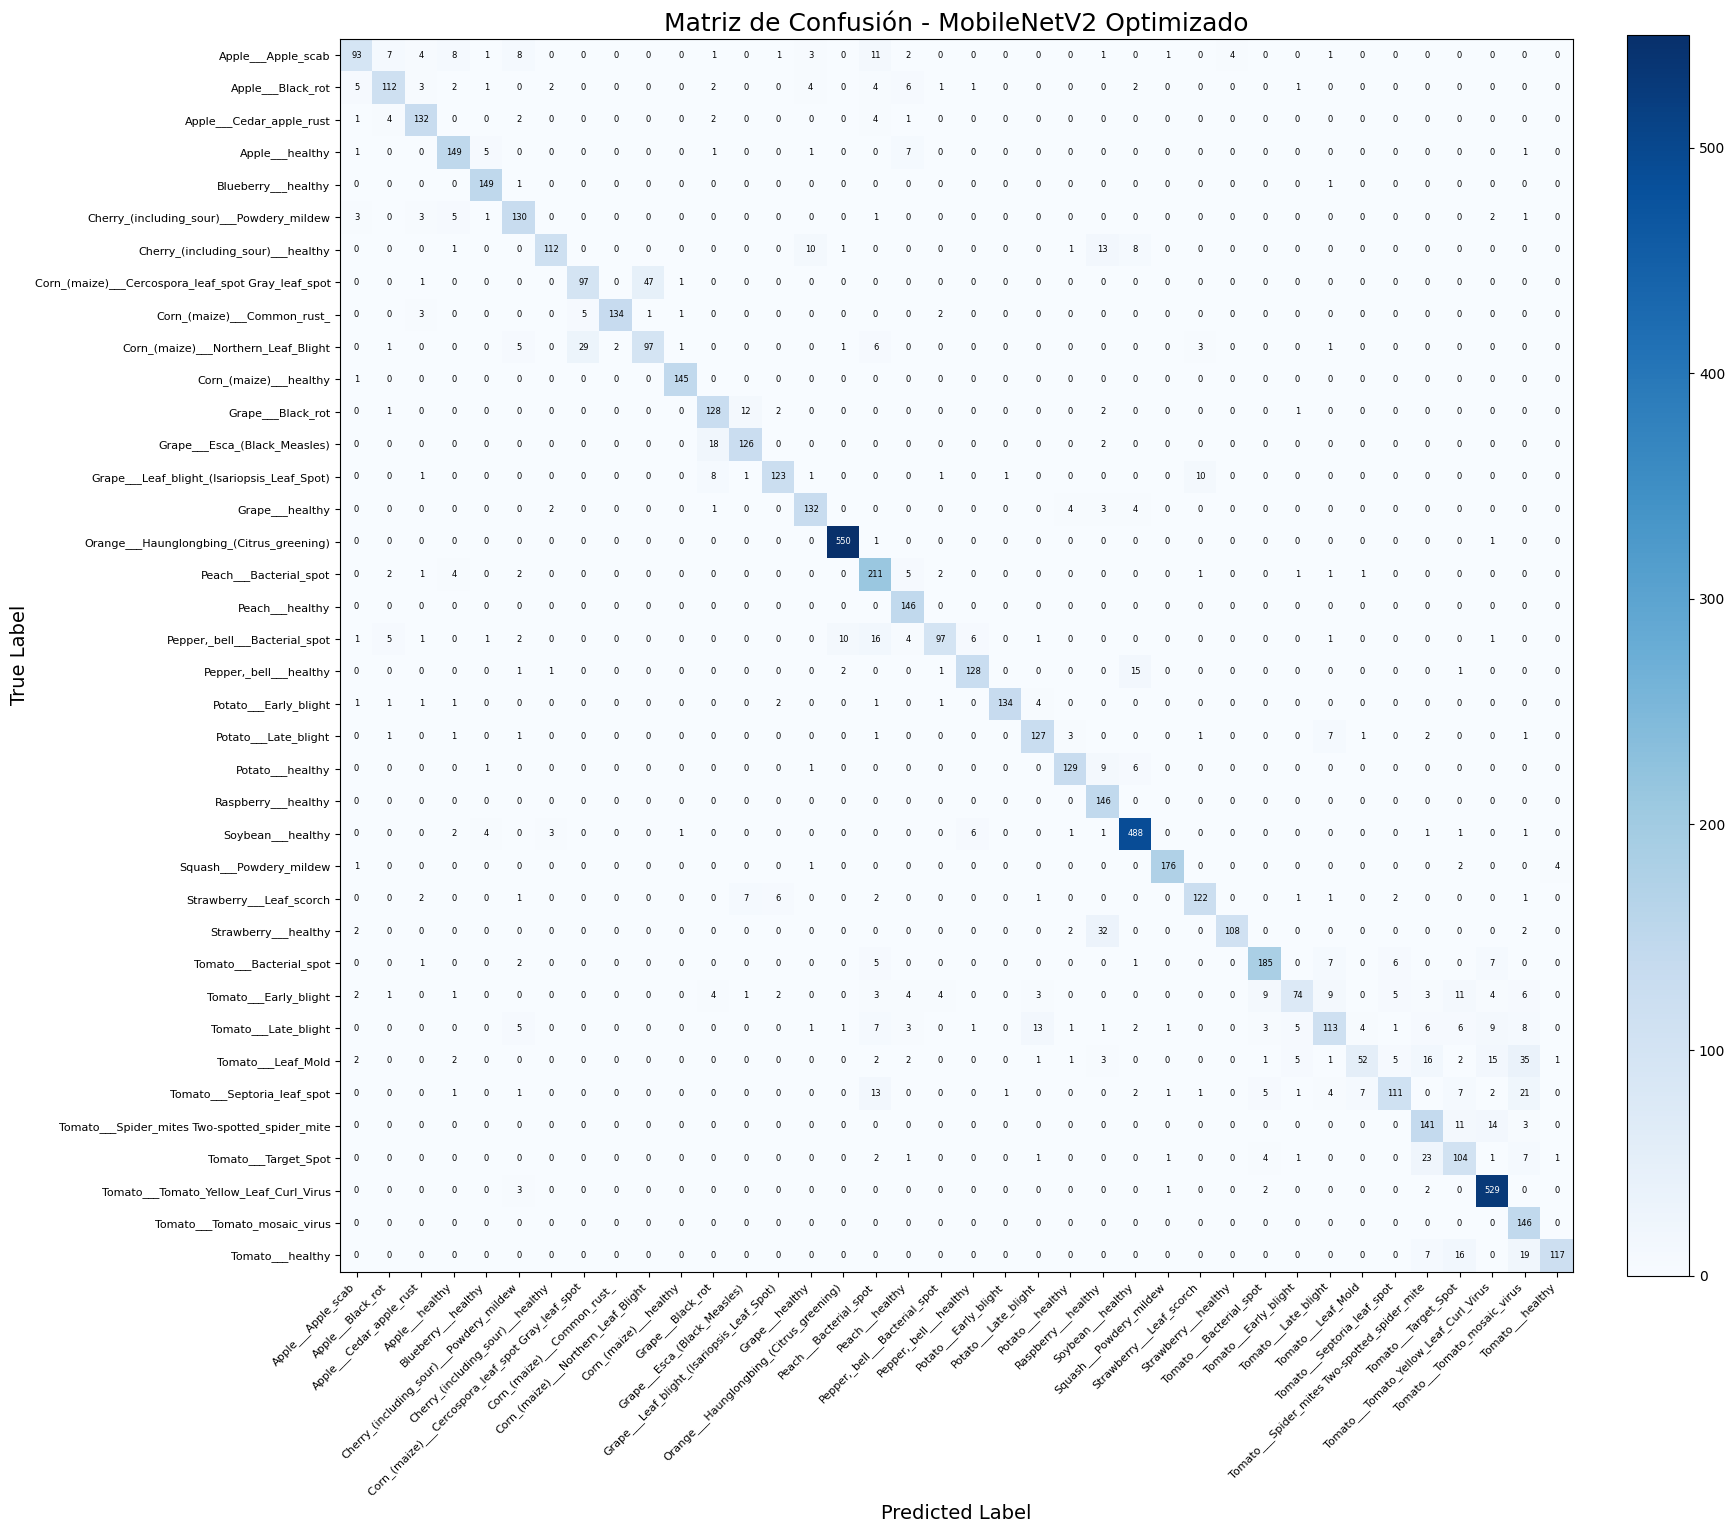

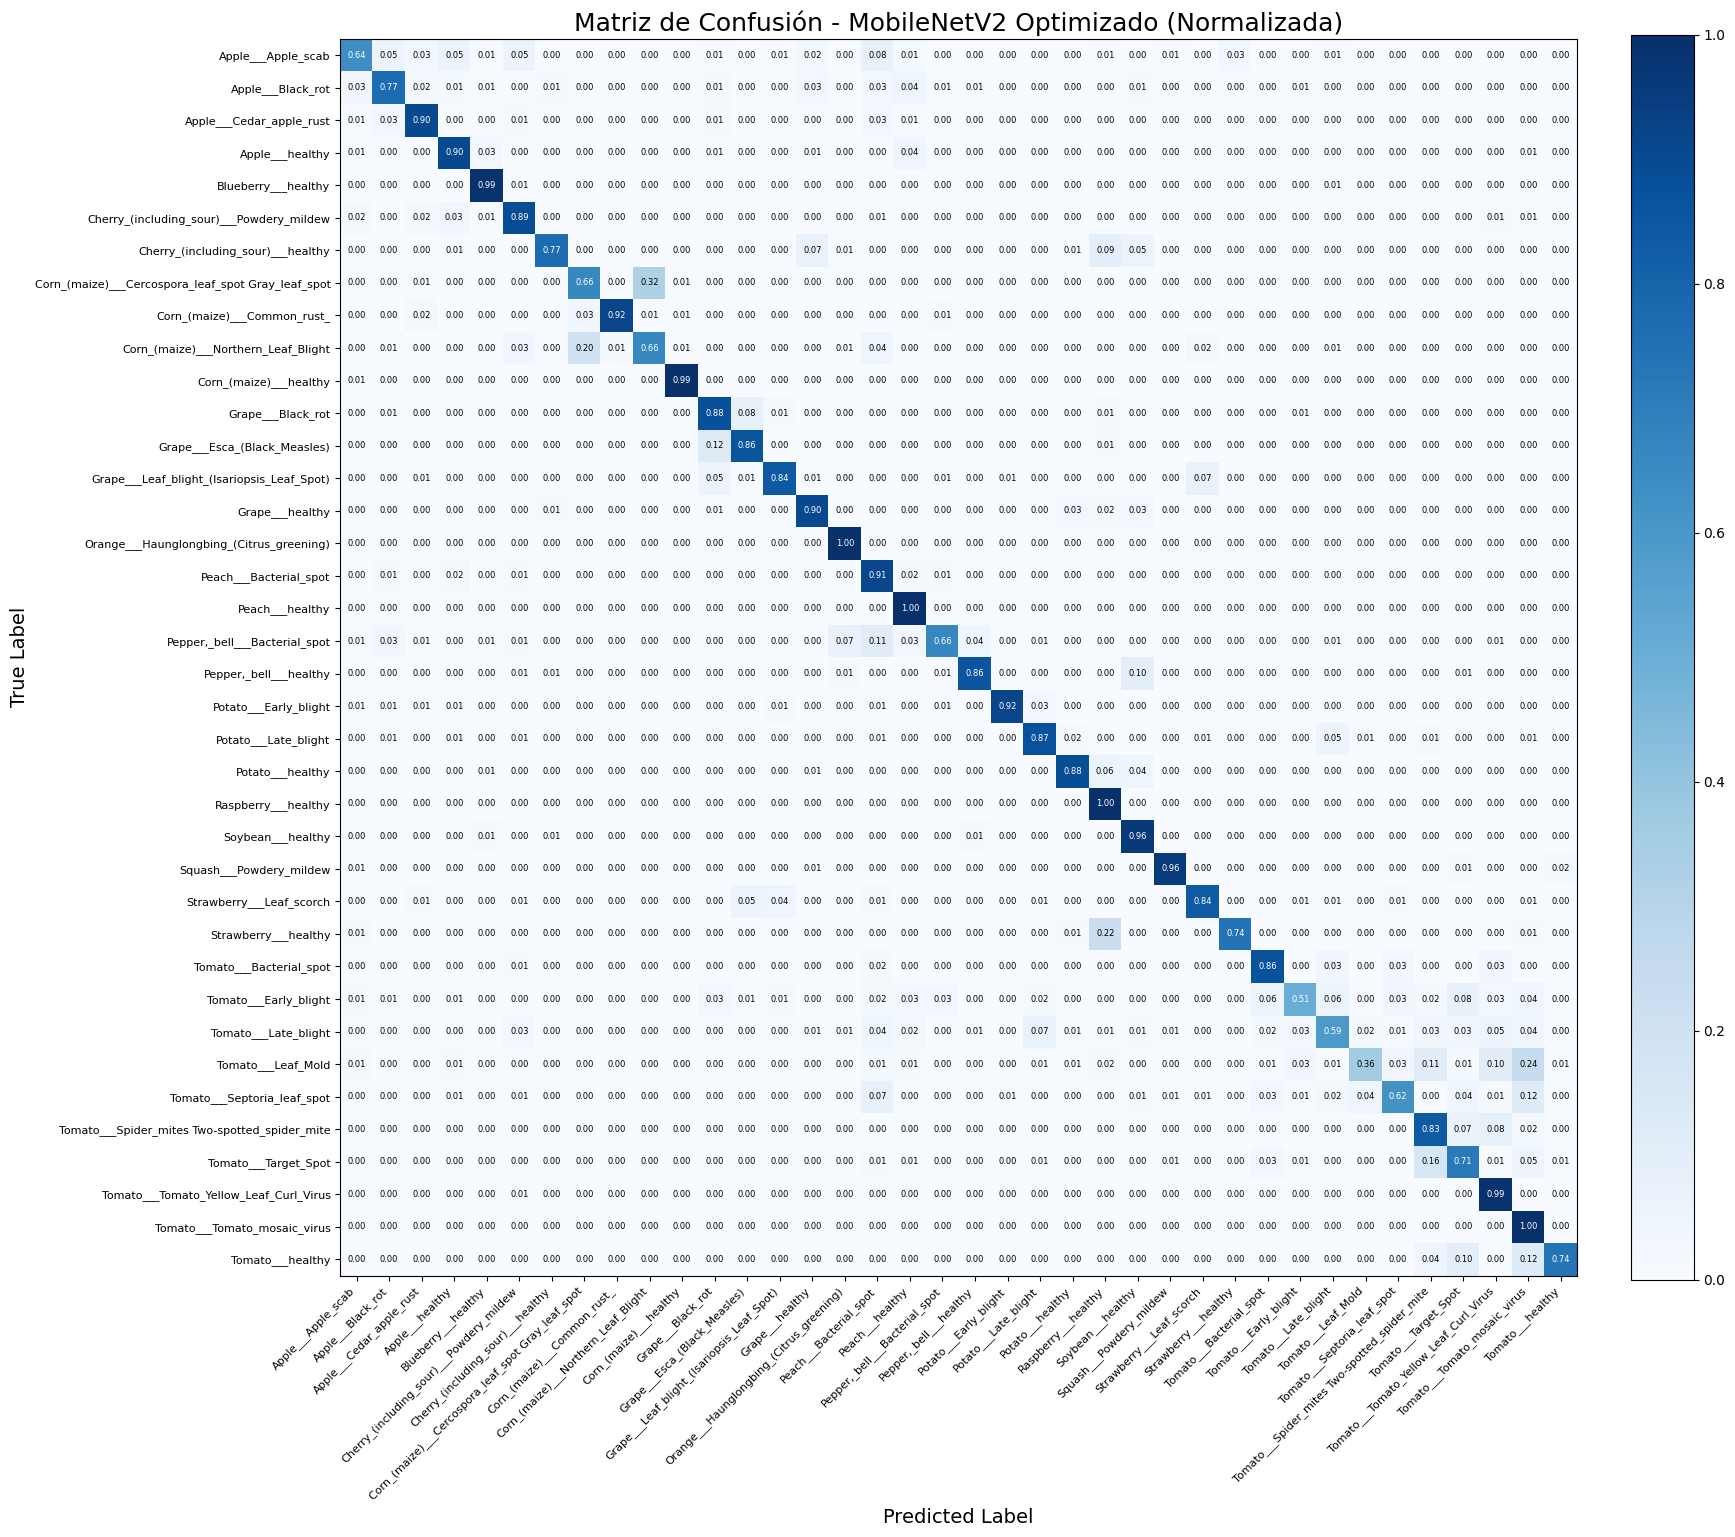

Overall Accuracy MobileNetV2: 0.8514
Recall Macro MobileNetV2: 0.8260

Classification Report MobileNetV2:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.82      0.64      0.72       146
                                 Apple___Black_rot       0.83      0.77      0.80       146
                          Apple___Cedar_apple_rust       0.86      0.90      0.88       146
                                   Apple___healthy       0.84      0.90      0.87       165
                               Blueberry___healthy       0.91      0.99      0.95       151
          Cherry_(including_sour)___Powdery_mildew       0.79      0.89      0.84       146
                 Cherry_(including_sour)___healthy       0.93      0.77      0.84       146
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.74      0.66      0.70       146
                       Corn_(maize)___Common_rust_       0.99   

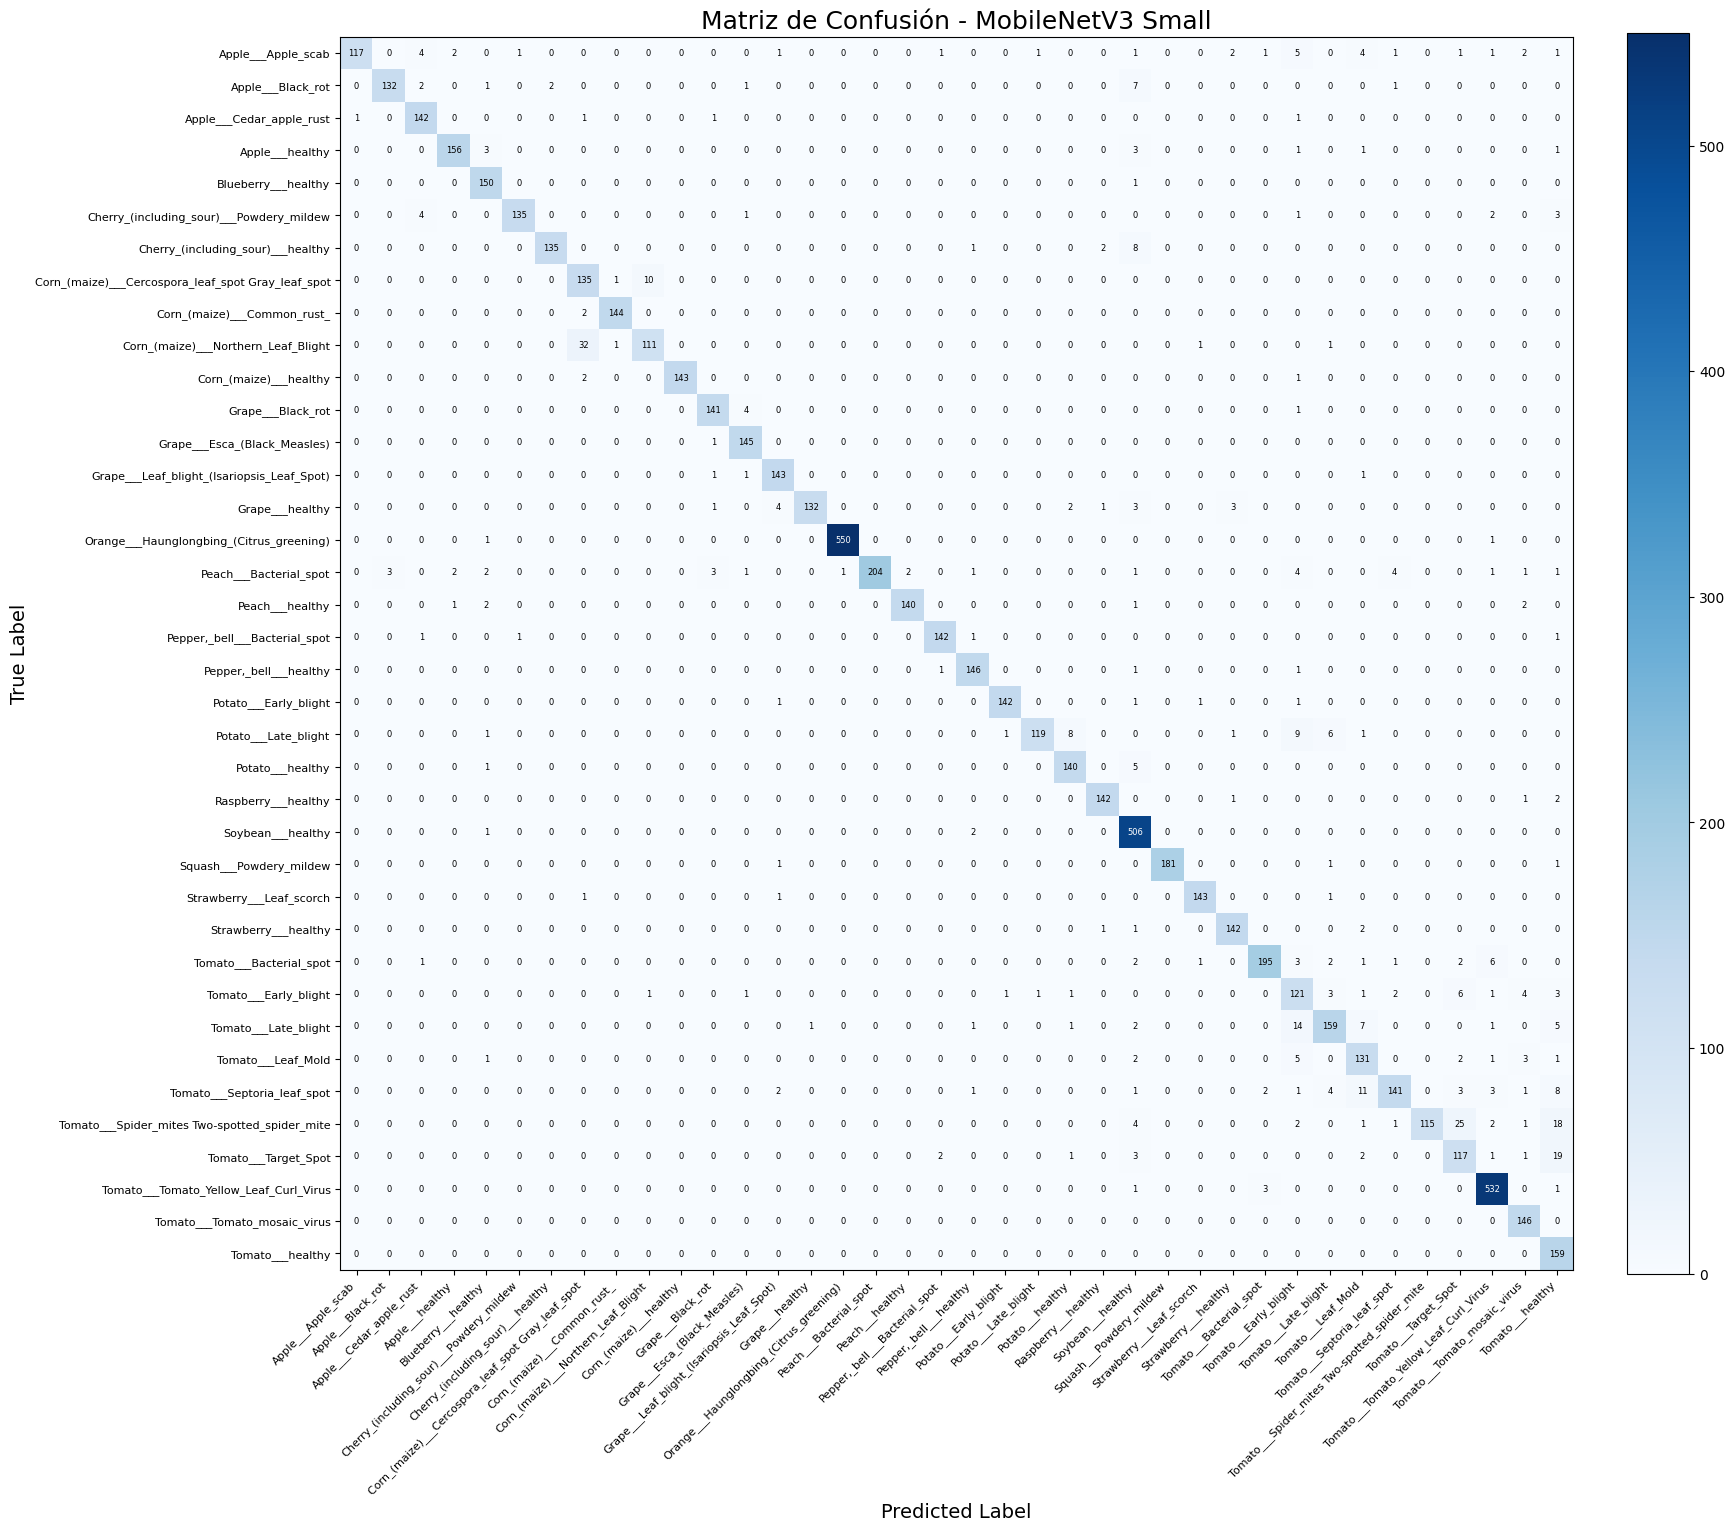

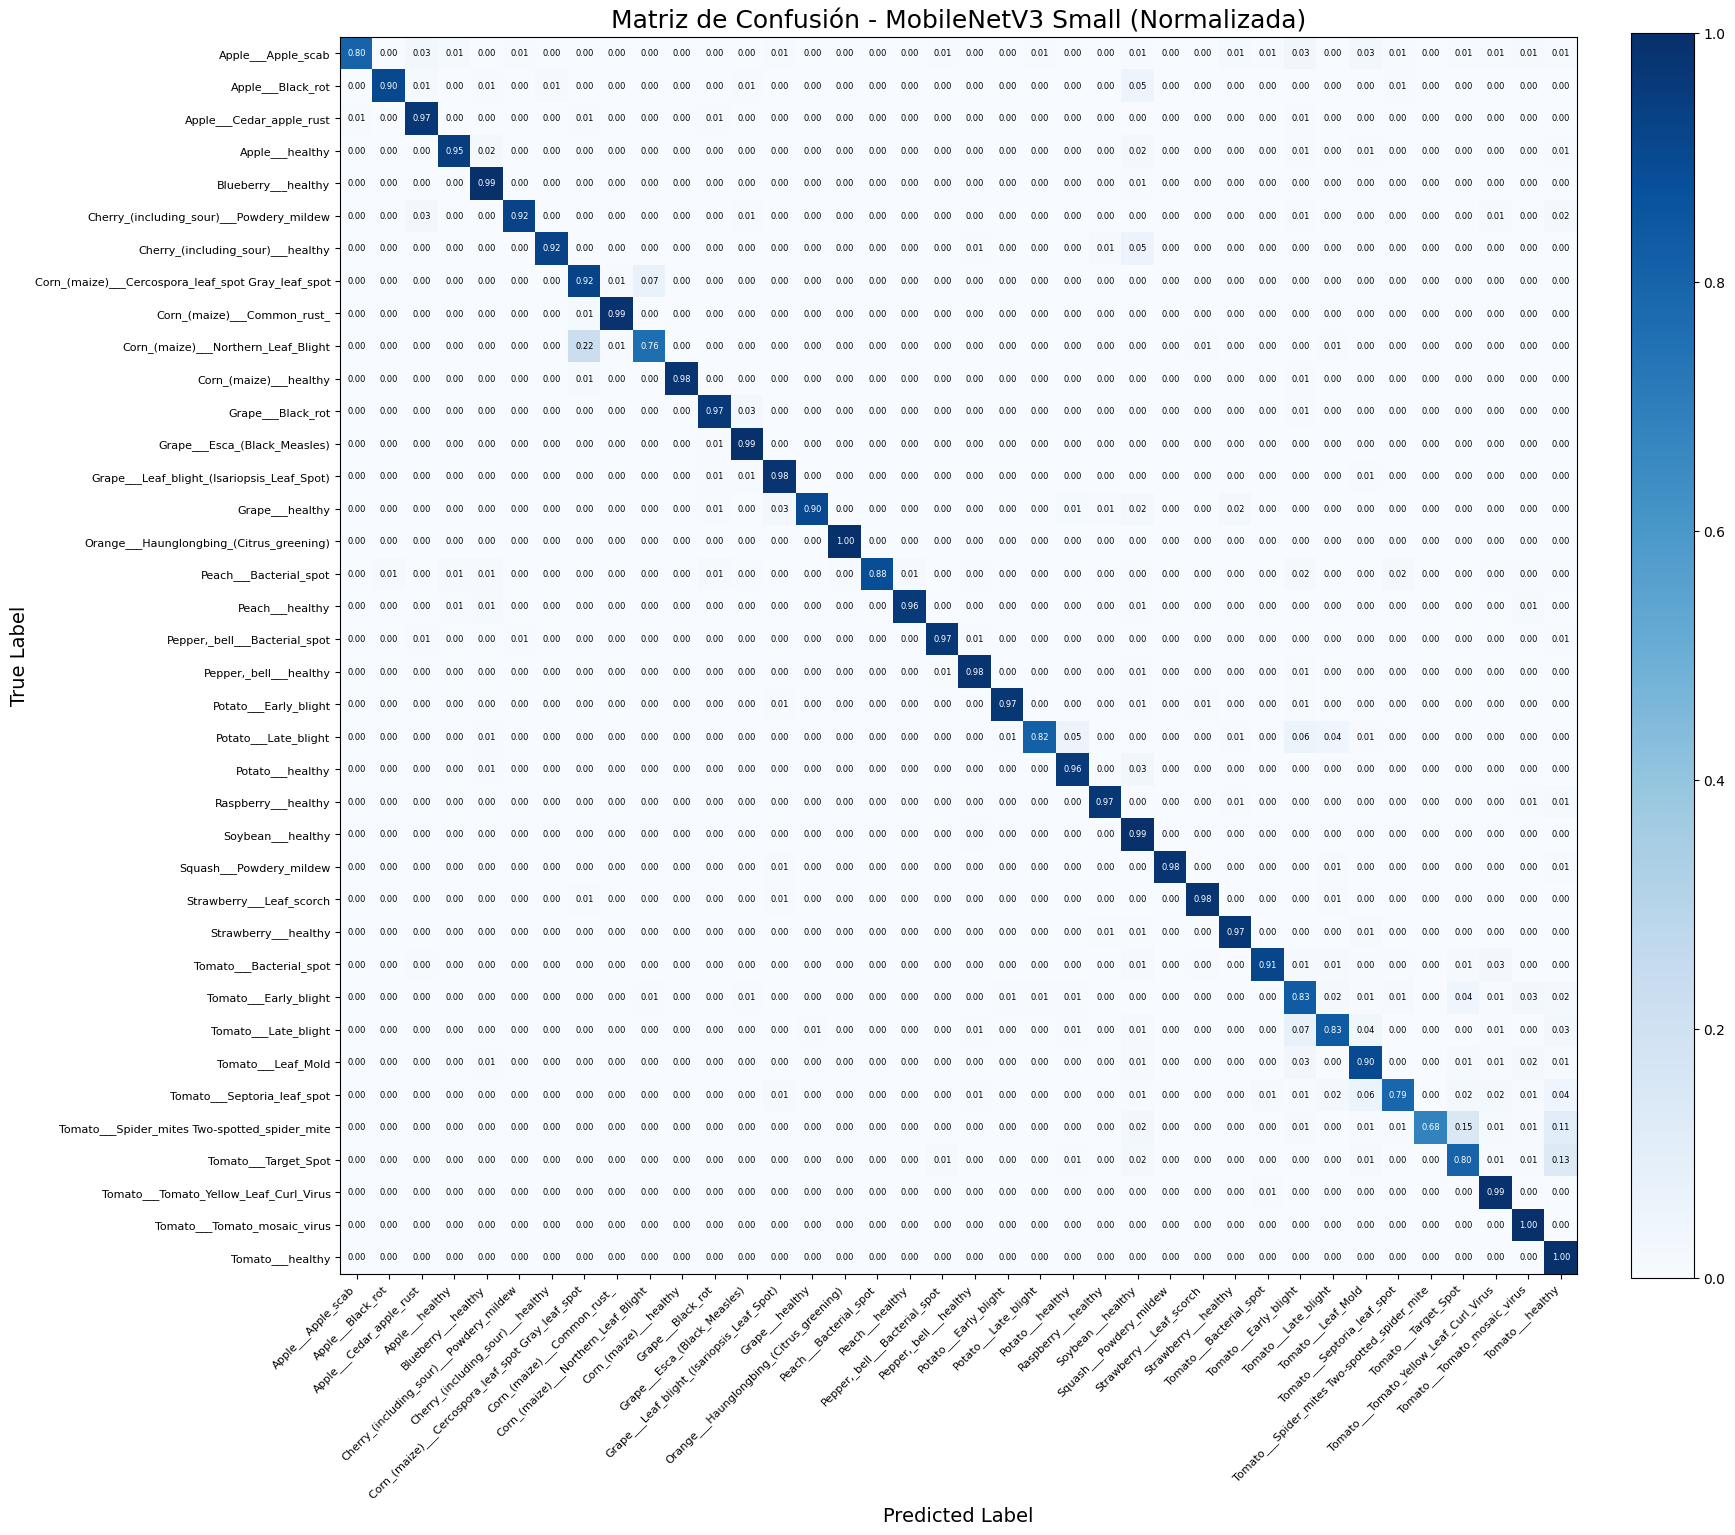

Overall Accuracy MobileNetV3: 0.9339
Recall Macro MobileNetV3: 0.9246

Classification Report MobileNetV3:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.80      0.89       146
                                 Apple___Black_rot       0.98      0.90      0.94       146
                          Apple___Cedar_apple_rust       0.92      0.97      0.95       146
                                   Apple___healthy       0.97      0.95      0.96       165
                               Blueberry___healthy       0.92      0.99      0.96       151
          Cherry_(including_sour)___Powdery_mildew       0.99      0.92      0.95       146
                 Cherry_(including_sour)___healthy       0.99      0.92      0.95       146
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.92      0.85       146
                       Corn_(maize)___Common_rust_       0.99   

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

# --- Función para crear matriz de confusión y retornar predicciones y etiquetas ---
def create_confusion_matrix(model, dataloader, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, numerical_features, labels in dataloader:
            images = images.to(device)
            numerical_features = numerical_features.to(device)
            labels = labels.to(device)

            outputs = model(images, numerical_features)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds

# --- Función para graficar matriz de confusión ---
def plot_cm(cm, classes, title, cmap=plt.cm.Blues, normalize=False):
    if normalize:
        cm_to_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title += " (Normalizada)"
    else:
        cm_to_plot = cm
        fmt = 'd'

    plt.figure(figsize=(20, 20))
    plt.imshow(cm_to_plot, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    thresh = cm_to_plot.max() / 2.
    for i in range(cm_to_plot.shape[0]):
        for j in range(cm_to_plot.shape[1]):
            plt.text(j, i, format(cm_to_plot[i, j], fmt),
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=6,
                     color="white" if cm_to_plot[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right', fontsize=8)
    plt.yticks(ticks=np.arange(len(classes)), labels=classes, fontsize=8)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3, left=0.3)
    plt.show()


# ------------------- MobileNetV2 -------------------
cm_v2, all_labels_v2, all_preds_v2 = create_confusion_matrix(model_v2_opt, dataloaders['test'], device='cpu')

# Graficar matriz de confusión
plot_cm(cm_v2, train_dataset.classes, "Matriz de Confusión - MobileNetV2 Optimizado")
plot_cm(cm_v2, train_dataset.classes, "Matriz de Confusión - MobileNetV2 Optimizado", normalize=True)

# Métricas y reporte
overall_acc_v2 = accuracy_score(all_labels_v2, all_preds_v2)
recall_macro_v2 = recall_score(all_labels_v2, all_preds_v2, average='macro', zero_division=0)
report_v2 = classification_report(all_labels_v2, all_preds_v2, target_names=train_dataset.classes, zero_division=0)

print(f"Overall Accuracy MobileNetV2: {overall_acc_v2:.4f}")
print(f"Recall Macro MobileNetV2: {recall_macro_v2:.4f}\n")
print("Classification Report MobileNetV2:\n")
print(report_v2)


# ------------------- MobileNetV3 -------------------
cm_v3, all_labels_v3, all_preds_v3 = create_confusion_matrix(model_v3_opt, dataloaders['test'], device='cpu')

# Graficar matriz de confusión
plot_cm(cm_v3, train_dataset.classes, "Matriz de Confusión - MobileNetV3 Small")
plot_cm(cm_v3, train_dataset.classes, "Matriz de Confusión - MobileNetV3 Small", normalize=True)

# Métricas y reporte
overall_acc_v3 = accuracy_score(all_labels_v3, all_preds_v3)
recall_macro_v3 = recall_score(all_labels_v3, all_preds_v3, average='macro', zero_division=0)
report_v3 = classification_report(all_labels_v3, all_preds_v3, target_names=train_dataset.classes, zero_division=0)

print(f"Overall Accuracy MobileNetV3: {overall_acc_v3:.4f}")
print(f"Recall Macro MobileNetV3: {recall_macro_v3:.4f}\n")
print("Classification Report MobileNetV3:\n")
print(report_v3)

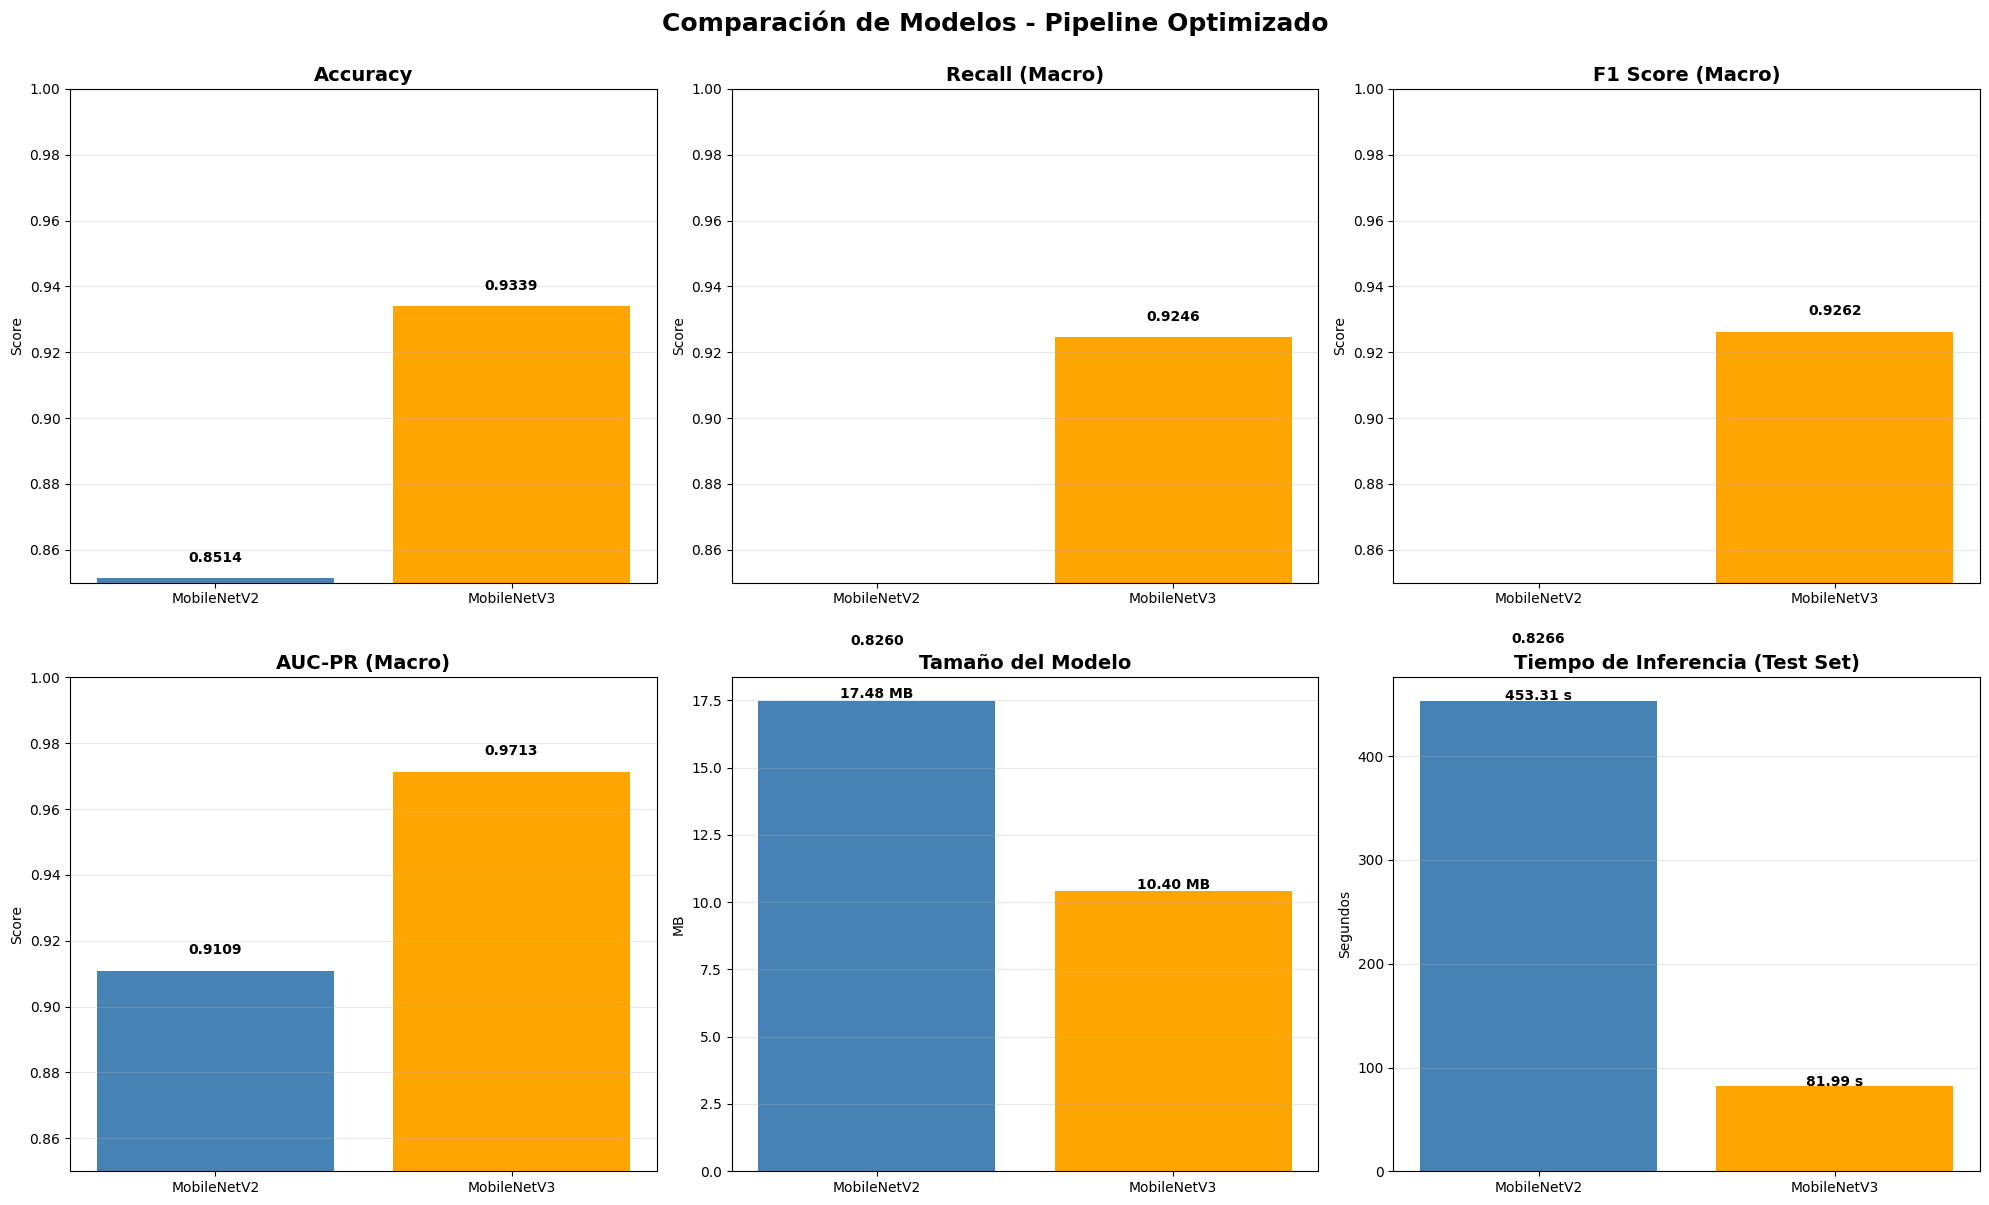

In [ ]:
# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

models_list = df_results.index.tolist()
colors = ['steelblue', 'orange', 'forestgreen']

# 1. Accuracy
axes[0, 0].bar(models_list, df_results['Accuracy'], color=colors)
axes[0, 0].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0.85, 1.0)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['Accuracy']):
    axes[0, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Recall
axes[0, 1].bar(models_list, df_results['Recall'], color=colors)
axes[0, 1].set_title('Recall (Macro)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim(0.85, 1.0)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['Recall']):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 3. F1 Score
axes[0, 2].bar(models_list, df_results['F1 Score'], color=colors)
axes[0, 2].set_title('F1 Score (Macro)', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_ylim(0.85, 1.0)
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['F1 Score']):
    axes[0, 2].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 4. AUC-PR
axes[1, 0].bar(models_list, df_results['AUC-PR'], color=colors)
axes[1, 0].set_title('AUC-PR (Macro)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim(0.85, 1.0)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['AUC-PR']):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 5. Tamaño del modelo
axes[1, 1].bar(models_list, df_results['Size (MB)'], color=colors)
axes[1, 1].set_title('Tamaño del Modelo', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('MB')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['Size (MB)']):
    axes[1, 1].text(i, v + 0.1, f'{v:.2f} MB', ha='center', fontweight='bold')

# 6. Tiempo de inferencia
axes[1, 2].bar(models_list, df_results['Inference Time (s)'], color=colors)
axes[1, 2].set_title('Tiempo de Inferencia (Test Set)', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Segundos')
axes[1, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(df_results['Inference Time (s)']):
    axes[1, 2].text(i, v + 0.5, f'{v:.2f} s', ha='center', fontweight='bold')

plt.suptitle('Comparación de Modelos - Pipeline Optimizado',
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


## 10. Análisis de Mejoras

Comparamos el impacto de nuestras optimizaciones:


In [ ]:
print("="*70)
print("ANÁLISIS DE MEJORAS IMPLEMENTADAS")
print("="*70)

print("\n1️⃣ ELIMINACIÓN DE DUPLICADOS")
print(f"   • Imágenes duplicadas eliminadas: {removed if duplicates else 0}")
print(f"   • Beneficio: Reduce overfitting y mejora generalización")

print("\n2️⃣ DATA AUGMENTATION SELECTIVO")
print(f"   • Imágenes sintéticas generadas: {generated_images}")
print(f"   • Clases balanceadas: {len(underrepresented_classes)}")
print(f"   • Beneficio: Mejora rendimiento en clases minoritarias")

print("\n3️⃣ OPTIMIZACIÓN DE HIPERPARÁMETROS (OPTUNA)")

optuna_results = {
    "MobileNetV2": {"study": study_v2, "best_params": best_params_v2},
    "MobileNetV3": {"study": study_v3, "best_params": best_params_v3},
}

for model_name, data in optuna_results.items():
    print(f"\n   • Resultados Optuna para {model_name}:")
    print(f"     - Trials ejecutados: {len(data['study'].trials)}")
    print(f"     - Mejor AUC PR encontrado: {data['study'].best_value:.4f}")
    print("     - Hiperparámetros óptimos:")
    for key, value in data['best_params'].items():
        print(f"       - {key}: {value}")
print(f"   • Beneficio: Configuración óptima automática para cada modelo")

print("\n4️⃣ RESULTADOS FINALES")
print(f"   • Mejor modelo (precisión): {df_results['Accuracy'].idxmax()}")
print(f"     - Accuracy: {df_results['Accuracy'].max():.4f}")
print(f"     - Recall: {df_results.loc[df_results['Accuracy'].idxmax(), 'Recall']:.4f}")
print(f"     - F1 Score: {df_results.loc[df_results['Accuracy'].idxmax(), 'F1 Score']:.4f}")

print(f"\n   • Mejor modelo (tamaño): {df_results['Size (MB)'].idxmin()}")
print(f"     - Tamaño: {df_results['Size (MB)'].min():.2f} MB")
print(f"     - Accuracy: {df_results.loc[df_results['Size (MB)'].idxmin(), 'Accuracy']:.4f}")

print(f"\n   • Mejor modelo (velocidad): {df_results['Inference Time (s)'].idxmin()}")
print(f"     - Tiempo: {df_results['Inference Time (s)'].min():.2f} segundos")
print(f"     - Accuracy: {df_results.loc[df_results['Inference Time (s)'].idxmin(), 'Accuracy']:.4f}")

print("\n" + "="*70)

ANÁLISIS DE MEJORAS IMPLEMENTADAS

1️⃣ ELIMINACIÓN DE DUPLICADOS
   • Imágenes duplicadas eliminadas: 21
   • Beneficio: Reduce overfitting y mejora generalización

2️⃣ DATA AUGMENTATION SELECTIVO
   • Imágenes sintéticas generadas: 1054
   • Clases balanceadas: 25
   • Beneficio: Mejora rendimiento en clases minoritarias

3️⃣ OPTIMIZACIÓN DE HIPERPARÁMETROS (OPTUNA)

   • Resultados Optuna para MobileNetV2:
     - Trials ejecutados: 5
     - Mejor AUC PR encontrado: 0.0423
     - Hiperparámetros óptimos:
       - lr: 0.0008200518402245837
       - batch_size: 64
       - hidden_dim: 512
       - num_layers: 3
       - dropout: 0.20351199264000677
       - optimizer: SGD
       - weight_decay: 3.632486956676606e-05

   • Resultados Optuna para MobileNetV3:
     - Trials ejecutados: 5
     - Mejor AUC PR encontrado: 0.0415
     - Hiperparámetros óptimos:
       - lr: 0.03142880890840111
       - batch_size: 32
       - hidden_dim: 512
       - num_layers: 1
       - dropout: 0.344741157

## 11. Conclusiones y Recomendaciones

### Resumen de Optimizaciones Implementadas

**1. Eliminación de Duplicados**
- Detectamos y eliminamos imágenes duplicadas usando hashing perceptual
- Esto reduce el sesgo de memorización y mejora la generalización del modelo
- El dataset resultante es más limpio y representativo

**2. Data Augmentation Inteligente**
- Aplicamos augmentation **solo** a las clases con representación inferior al 80% del promedio
- Generamos imágenes sintéticas con transformaciones realistas (rotación, flip, color jitter)
- Resultado: Dataset más balanceado sin sobre-aumentar clases ya bien representadas

**3. Optimización de Hiperparámetros con Optuna**
- Búsqueda automática de:
  - Learning rate óptimo
  - Batch size
  - Arquitectura del clasificador (capas y neuronas)
  - Tipo de optimizer (SGD vs Adam)
  - Regularización (dropout, weight decay)
- Optuna utiliza Tree-structured Parzen Estimator (TPE) para búsqueda eficiente
- Pruning automático de trials no prometedores

### Comparación de Modelos

Los tres modelos entrenados muestran trade-offs diferentes:

**MobileNetV2 Optimizado:**
- Mejor accuracy y recall en general
- Modelo base robusto con hiperparámetros optimizados
- Mayor tamaño (~9 MB)
- Recomendado cuando la precisión es prioridad

**MobileNetV3 Small:**
- Excelente balance entre precisión y eficiencia
- ~50% más pequeño que V2
- Inferencia más rápida
- Recomendado para deployment móvil estándar



## 12. Guardar Modelos y Configuración

Guardamos los modelos entrenados y la configuración para uso posterior.


In [ ]:
# Guardar modelos
torch.save(model_v2_opt.state_dict(), 'mobilenetv2_optimized.pth')
torch.save(model_v3_opt.state_dict(), 'mobilenetv3_small.pth')

# Guardar hiperparámetros óptimos
import json

config = {
    'best_hyperparameters_v2': best_params_v2,
    'best_hyperparameters_v3': best_params_v3,
    'num_classes': num_classes,
    'class_names': train_dataset.classes, # <-- CAMBIO AQUÍ
    'results': results
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2, default=str)

print("✅ Modelos y configuración guardados:")
print("   - mobilenetv2_optimized.pth")
print("   - mobilenetv3_small.pth")
print("   - model_config.json")

# Guardar resultados en CSV
df_results.to_csv('model_comparison_results.csv')
print("   - model_comparison_results.csv")

✅ Modelos y configuración guardados:
   - mobilenetv2_optimized.pth
   - mobilenetv3_small.pth
   - model_config.json
   - model_comparison_results.csv
